# 处理数据

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import warnings
import datetime
from lightgbm import LGBMRegressor
from chinese_calendar import is_workday
import joblib
warnings.filterwarnings("ignore")

In [2]:

pd.options.display.max_columns=100 # to see columns 
df = pd.read_csv('process1.csv',encoding='utf-8')
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0


### 异常值简单处理

In [3]:
# 对价格异常值先删除一部分：
df.describe()

,销售区域编码,产品编码,产品大类编码,产品细类编码,产品价格,订单需求量,Year,Month,day,week,是否节假日
count,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000
mean,102.904318,21008.029884,304.932141,406.457362,1076.141512,91.683901,2017.013372,7.060494,16.902210,29.025597,0.262392
std,1.505023,590.908646,2.004253,3.107303,1167.576590,199.887129,0.921979,3.503281,8.399885,15.298208,0.439935
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000,2015.000000,1.000000,1.000000,1.000000,0.000000
25%,102.000000,20518.000000,303.000000,404.000000,598.000000,10.000000,2016.000000,4.000000,10.000000,16.000000,0.000000
50%,103.000000,20976.000000,306.000000,407.000000,883.000000,29.000000,2017.000000,8.000000,17.000000,32.000000,0.000000
75%,105.000000,21521.000000,306.000000,408.000000,1291.000000,101.000000,2018.000000,10.000000,24.000000,43.000000,1.000000
max,105.000000,22084.000000,308.000000,412.000000,260014.000000,16308.000000,2018.000000,12.000000,31.000000,53.000000,1.000000


Text(0.5, 1.0, '产品价格')

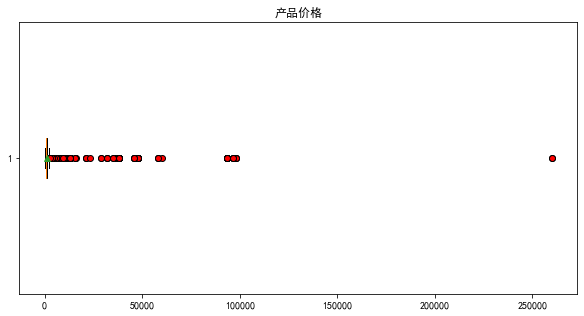

In [4]:
#产品价格特征异常值检查
plt.figure(figsize=(10,5))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
a1 = plt.boxplot(df['产品价格'],vert=False,showmeans=True,flierprops={"marker":"o","markerfacecolor":"red"})
plt.title('产品价格')

In [5]:
df[df['产品价格'] >50000]   ###后面的分箱操作就是处理价格异常值的，不过在分箱的过程时，不能因为两个26万的产品而多分一个箱子，
#所以删除掉两个异常值
df=df[df['产品价格'] <100000] #用小于10万方式，去掉26万的异常值
df 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0


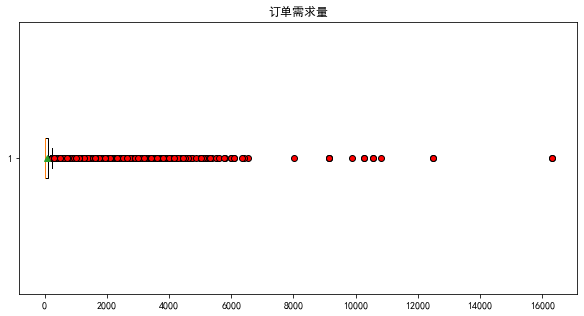

In [6]:
#再查看需求量异常值： 在df.describe()中可以知道需求量有max16308，
#产品价格特征异常值检查
plt.figure(figsize=(10,5))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
a1 = plt.boxplot(df['订单需求量'],vert=False,showmeans=True,flierprops={"marker":"o","markerfacecolor":"red"})
plt.title('订单需求量')
plt.savefig('订单需求量-原始.jpg',dpi=200)

In [7]:
df[df['订单需求量'] >6000] 
df=df[df['订单需求量'] <6000]
df 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0


### 构造促销列

In [8]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12','10-1','6-18']

cuxs=[]

#再得到日期是否是自己自定义的促销日：
# for index ,row in df.iterrows():
#     str_date = str(row['Month'])+'-'+str(row['day'])
#     if str_date in list_cux:
# #         print(str_date)
#         cuxs.append(1)
#     else:
#         cuxs.append(0)
for index, row in df.iterrows():
    str_date = str(row['Month']) + '-' + str(row['day'])
    if str_date in list_cux:
        if str_date in ['11-11', '12-12','6-18']:
            cuxs.append(2)
        else:
            cuxs.append(1)
    else:
        cuxs.append(0)

df['是否促销日']=cuxs
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0,0
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0,0
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0,0
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0,0
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0,0
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0,0
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0,0


### 构造D列

In [9]:
dt1 = pd.date_range(start="20150901", end="20181220", freq="D")
dt1
dicts = {}
i =1
for date in dt1:
#     print(str(date).split(' ')[0])
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
df['D'] = df['订单日期'].map(dicts)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0,0,2
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0,0,2
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0,0,1207
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0,0,1207
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207


In [10]:
len(set(df['产品编码']))

1758

In [11]:
len(set(df['产品价格']))

14362

### 重新对价格进行更细致的分箱编码

In [12]:
from scipy.stats import stats
def optimal_bins(Y,X,n):
    """
    :Y  目标变量
    ：X  待分箱特征
    ：n 分箱数初始值
    return : 统计值，分箱边界值列表、woe值、iv值
    """
    r = 0  #xia相关系数的初始值
    total_bad = Y.sum()  #总的坏样本数
    total_good = Y.count() - total_bad   #总的好样本数
    #分箱过程
    while np.abs(r) <1:   #相关系数的绝对值等于1结束循环，循环目的找寻最好正反相关性
        #df1中的bin为给X分箱对应的结果
        df1 = pd.DataFrame({'X':X,'Y':Y,'bin':pd.qcut(X,n,duplicates='drop')})  #drop表示删除重复元素
        #将df1基于箱子进行分组
        df2 = df1.groupby('bin')
        #r返回的是df1对箱子分组后，每组数据X的均值的相关系数，如果系数不为正负1，则减少分箱的箱数
        r,p = stats.spearmanr(df2.mean().X,df2.mean().Y) #计算相关系数
        n = n-1
    cut =[0]  #分箱边界值列表
    for i in range(1,n+2):  #i的取值范围是1->（n+1），n+1是分箱的数量
        qua = X.quantile(i/(n+1)) #quantile把给定的乱序的数值有小到大并列分成n等份，参数表述取出第百分之多少大小的数值
                                    #i的取值范围是1->n 1/n.2/n 3/n...n/n
        cut.append(round(qua,6))
   
    return cut
#对RevolvingRatio列进行分箱操作：
cut_bins = optimal_bins(df.订单需求量,df.产品价格,n=10)
cut_bins
df['价格区间'] = pd.cut(df['产品价格'],cut_bins,labels=[x for x in range(len(cut_bins)-1)])
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间
0,2015-09-01,104,22069,307,403,offline,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4
1,2015-09-01,104,20028,301,405,offline,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4
2,2015-09-02,104,21183,307,403,online,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0
3,2015-09-02,104,20448,308,404,online,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,offline,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3
597378,2018-12-20,102,21875,302,408,offline,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2
597379,2018-12-20,102,20215,302,408,offline,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6
597380,2018-12-20,102,20195,302,408,offline,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6


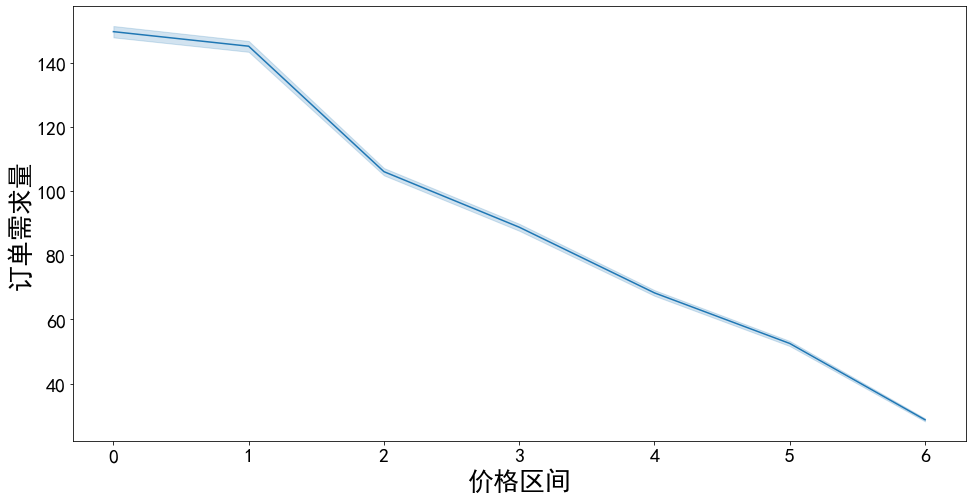

In [130]:
plt.figure(figsize=(16,8))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
sns.lineplot(x='价格区间', y='订单需求量', data=df)
plt.xlabel('价格区间',fontsize=26)
plt.ylabel('订单需求量',fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('1.jpg',dpi=200)
plt.show()

###  利用map映射对“渠道”和“月头、月中..”编码处理

In [14]:
dict_qudao = {'offline':0,'online':1}
dict_moth = {'月初':0,'月中':1,'月末':2}
df.销售渠道名称 = df.销售渠道名称.map(dict_qudao)
df['每月时间段'] =df.标签.map(dict_moth)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1


### 根据第一问分析，需要对每个地区季节再进行分类和标签编码¶

In [15]:
df["season"] = df["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})
df
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
df['season_bm'] =df.season.map(dict_season)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段,season,season_bm
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0,秋季,2
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0,秋季,2
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0,秋季,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1,冬季,3
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1,冬季,3
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3


### 构造新特征，日期为每周星期几、工作日还是休息日

In [16]:

df['订单日期'] = pd.to_datetime(df['订单日期'])  #对日期列进行日期格式转换
df['星期几'] = df.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段,season,season_bm,星期几
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0,秋季,2,2
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0,秋季,2,2
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0,秋季,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1,冬季,3,3
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1,冬季,3,3
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3


In [17]:
df['is_workday']=df['订单日期'].map(lambda x:is_workday(x))
df
dict_is_workday = {False:0,True:1}
df['is_workday'] =df.is_workday.map(dict_is_workday)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,Year,Month,day,week,grade,标签,是否节假日,是否促销日,D,价格区间,每月时间段,season,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,1114.0,19,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1,1
1,2015-09-01,104,20028,301,405,0,1012.0,12,2015,9,1,36,较高价格,月初,0,0,1,4,0,秋季,2,1,1
2,2015-09-02,104,21183,307,403,1,428.0,109,2015,9,2,36,低价格,月初,0,0,2,0,0,秋季,2,2,1
3,2015-09-02,104,20448,308,404,1,962.0,3,2015,9,2,36,较高价格,月初,0,0,2,3,0,秋季,2,2,1
4,2015-09-02,104,21565,307,403,0,1400.0,3,2015,9,2,36,高价格,月初,0,0,2,5,0,秋季,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,843.0,59,2018,12,20,51,中价格,月中,0,0,1207,3,1,冬季,3,3,1
597378,2018-12-20,102,21875,302,408,0,762.0,502,2018,12,20,51,中价格,月中,0,0,1207,2,1,冬季,3,3,1
597379,2018-12-20,102,20215,302,408,0,2013.0,106,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3,1
597380,2018-12-20,102,20195,302,408,0,2120.0,187,2018,12,20,51,高价格,月中,0,0,1207,6,1,冬季,3,3,1


### 删除无用列，整理df

In [18]:
df.drop(['产品价格','week','grade','标签','season'],axis=1,inplace=True)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1


In [19]:
df.to_csv("data/proess_transform.csv",index=False)  #保存数据，用于后续预测出19-01年数据后进行拼接，将19-01月数据添加在这个数据后
#作为训练集。再去预测19-02月的数据。

In [20]:
df.info()  #下面构造的时候，也需要最后转为同样的类型

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597361 entries, 0 to 597381
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        597361 non-null  datetime64[ns]
 1   销售区域编码      597361 non-null  int64         
 2   产品编码        597361 non-null  int64         
 3   产品大类编码      597361 non-null  int64         
 4   产品细类编码      597361 non-null  int64         
 5   销售渠道名称      597361 non-null  int64         
 6   订单需求量       597361 non-null  int64         
 7   Year        597361 non-null  int64         
 8   Month       597361 non-null  int64         
 9   day         597361 non-null  int64         
 10  是否节假日       597361 non-null  int64         
 11  是否促销日       597361 non-null  int64         
 12  D           597361 non-null  int64         
 13  价格区间        597361 non-null  category      
 14  每月时间段       597361 non-null  int64         
 15  season_bm   597361 non-null  int64         
 16  星期

### 增加待预测的三个月数据（2019年1,2,3,月）

In [21]:
#在 构造待预测数据之前，我们先剔除掉104地区的数据，因为不需要对该数据预测

temp = df[df['销售区域编码']!=104]
temp #减少了2w多数据



,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
8,2015-09-02,102,20323,305,412,0,502,2015,9,2,0,0,2,0,0,2,2,1
9,2015-09-02,102,21350,305,412,0,107,2015,9,2,0,0,2,0,0,2,2,1
10,2015-09-02,101,20657,303,410,0,18,2015,9,2,0,0,2,6,0,2,2,1
11,2015-09-02,102,20457,305,412,0,308,2015,9,2,0,0,2,0,0,2,2,1
12,2015-09-03,102,21052,303,401,0,14,2015,9,3,1,0,3,5,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1


In [22]:

temp['zuhe'] = temp['销售区域编码'].astype(str)+'_'+temp['产品大类编码'].astype(str)+'_'+temp['产品细类编码'].astype(str)+'_'+temp['产品编码'].astype(str)
temp


,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,zuhe
8,2015-09-02,102,20323,305,412,0,502,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20323
9,2015-09-02,102,21350,305,412,0,107,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_21350
10,2015-09-02,101,20657,303,410,0,18,2015,9,2,0,0,2,6,0,2,2,1,101_303_410_20657
11,2015-09-02,102,20457,305,412,0,308,2015,9,2,0,0,2,0,0,2,2,1,102_305_412_20457
12,2015-09-03,102,21052,303,401,0,14,2015,9,3,1,0,3,5,0,2,3,0,102_303_401_21052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1,102_302_408_20994
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1,102_302_408_21875
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1,102_302_408_20215
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1,102_302_408_20195


In [23]:
len(set(temp['zuhe'])) ## 完整给出的数据，剔除掉104区域后，有5109种产品，我们将先构造一下这5109种产品，每天的需求量为0，加入到原数据中
#先预测一个月的，再将一个月的数据加入到原始作为训练集，再去预测第二个月的，
#意思是先预测出5109种产品2019-1月的需求量，再去预测2019-2，最后时2019-3月。


#没去除104之前，产品有5366种，去掉后有5109种

5109

In [24]:
#从2018-12-21到2019-1-31日的数据

dt1 = pd.date_range(start="20181215", end="20190131", freq="D")
dt1
len(dt1)


48

In [25]:
dates=[]
need=[]
ids =[]
for d in dt1:
    date = str(d).split(' ')[0] #得到日期xx-xx-xx
    dates=dates+[date]*len(set(temp['zuhe']))
    need = need+[0]*len(set(temp['zuhe']))
    ids=ids+list(set(temp['zuhe']))
    

In [26]:
tempdf=pd.DataFrame()
tempdf['订单日期']=dates
tempdf['zuhe']=ids
tempdf['订单需求量']=need
tempdf  

,订单日期,zuhe,订单需求量
0,2018-12-15,101_303_410_20901,0
1,2018-12-15,103_302_408_21993,0
2,2018-12-15,105_308_404_20047,0
3,2018-12-15,105_306_402_22027,0
4,2018-12-15,102_303_401_20445,0
...,...,...,...
245227,2019-01-31,103_303_401_20072,0
245228,2019-01-31,102_305_412_21136,0
245229,2019-01-31,101_303_410_20377,0
245230,2019-01-31,101_306_407_21018,0


### chu处理tempdf为df的数据格式：

In [27]:
## chu处理tempdf为df的数据格式：

tempdf['销售区域编码']=tempdf['zuhe'].str.split('_',expand=True)[0]
tempdf['产品大类编码']=tempdf['zuhe'].str.split('_',expand=True)[1]
tempdf['产品细类编码']=tempdf['zuhe'].str.split('_',expand=True)[2]
tempdf['产品编码']=tempdf['zuhe'].str.split('_',expand=True)[3]
tempdf

,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码
0,2018-12-15,101_303_410_20901,0,101,303,410,20901
1,2018-12-15,103_302_408_21993,0,103,302,408,21993
2,2018-12-15,105_308_404_20047,0,105,308,404,20047
3,2018-12-15,105_306_402_22027,0,105,306,402,22027
4,2018-12-15,102_303_401_20445,0,102,303,401,20445
...,...,...,...,...,...,...,...
245227,2019-01-31,103_303_401_20072,0,103,303,401,20072
245228,2019-01-31,102_305_412_21136,0,102,305,412,21136
245229,2019-01-31,101_303_410_20377,0,101,303,410,20377
245230,2019-01-31,101_306_407_21018,0,101,306,407,21018


In [28]:
## 
import chinese_calendar
import datetime

tempdf['订单日期'] = pd.to_datetime(tempdf['订单日期'])  #对日期列进行日期格式转换
tempdf['Year'] = tempdf.订单日期.dt.year #分解出年份
tempdf['Month'] = tempdf.订单日期.dt.month
tempdf['day'] = tempdf.订单日期.dt.day

tempdf

import datetime
from chinese_calendar import is_holiday, is_workday
is_holidays =[]  #用来存放日期是否为节假日。1为是，0为不是
for index,row in tempdf.iterrows():
    day = datetime.date(int(row['Year']), int(row['Month']),int(row['day']))
    if is_holiday(day):
        is_holidays.append(1)
    else:
        is_holidays.append(0)
tempdf['是否节假日'] = is_holidays  #加入到表格汇总
tempdf

## 去掉104区域的产品，我们构造的待预测的数据集，从225372 降为214578  

,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日
0,2018-12-15,101_303_410_20901,0,101,303,410,20901,2018,12,15,1
1,2018-12-15,103_302_408_21993,0,103,302,408,21993,2018,12,15,1
2,2018-12-15,105_308_404_20047,0,105,308,404,20047,2018,12,15,1
3,2018-12-15,105_306_402_22027,0,105,306,402,22027,2018,12,15,1
4,2018-12-15,102_303_401_20445,0,102,303,401,20445,2018,12,15,1
...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103_303_401_20072,0,103,303,401,20072,2019,1,31,0
245228,2019-01-31,102_305_412_21136,0,102,305,412,21136,2019,1,31,0
245229,2019-01-31,101_303_410_20377,0,101,303,410,20377,2019,1,31,0
245230,2019-01-31,101_306_407_21018,0,101,306,407,21018,2019,1,31,0


In [29]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']
cuxs=[]

#再得到日期是否是自己自定义的促销日：
for index ,row in tempdf.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


tempdf['是否促销日']=cuxs
tempdf

,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日
0,2018-12-15,101_303_410_20901,0,101,303,410,20901,2018,12,15,1,0
1,2018-12-15,103_302_408_21993,0,103,302,408,21993,2018,12,15,1,0
2,2018-12-15,105_308_404_20047,0,105,308,404,20047,2018,12,15,1,0
3,2018-12-15,105_306_402_22027,0,105,306,402,22027,2018,12,15,1,0
4,2018-12-15,102_303_401_20445,0,102,303,401,20445,2018,12,15,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103_303_401_20072,0,103,303,401,20072,2019,1,31,0,0
245228,2019-01-31,102_305_412_21136,0,102,305,412,21136,2019,1,31,0,0
245229,2019-01-31,101_303_410_20377,0,101,303,410,20377,2019,1,31,0,0
245230,2019-01-31,101_306_407_21018,0,101,306,407,21018,2019,1,31,0,0


In [30]:
jagdf=temp[['zuhe','价格区间','销售渠道名称']]
jagdf.drop_duplicates(['zuhe'],keep='last',inplace=True)
jagdf

,zuhe,价格区间,销售渠道名称
52,101_306_407_21604,5,0
1172,102_306_402_21645,0,0
2003,102_302_408_21112,4,0
2258,105_306_407_20556,4,0
2261,105_306_407_21353,6,0
...,...,...,...
597377,102_302_408_20994,3,0
597378,102_302_408_21875,2,0
597379,102_302_408_20215,6,0
597380,102_302_408_20195,6,0


In [31]:
dict_jg = {}
qudao_dict={}
for i in range(len(jagdf)):
    dict_jg[list(jagdf['zuhe'])[i]]=list(jagdf['价格区间'])[i]
    qudao_dict[list(jagdf['zuhe'])[i]] = list(jagdf['销售渠道名称'])[i]
dict_jg
qudao_dict

{'101_306_407_21604': 0,
 '102_306_402_21645': 0,
 '102_302_408_21112': 0,
 '105_306_407_20556': 0,
 '105_306_407_21353': 0,
 '105_306_407_20883': 0,
 '105_306_407_21020': 0,
 '103_305_412_22062': 0,
 '102_306_407_20326': 0,
 '102_306_407_21952': 0,
 '101_306_407_21976': 0,
 '103_306_407_21401': 0,
 '103_306_407_21949': 0,
 '101_306_407_21079': 0,
 '102_302_408_21273': 0,
 '102_303_401_20435': 0,
 '103_303_401_20072': 0,
 '101_306_407_20622': 0,
 '103_302_408_21263': 0,
 '101_306_407_21275': 0,
 '102_302_408_21024': 0,
 '102_302_408_21351': 0,
 '102_302_408_20019': 0,
 '103_303_401_20372': 0,
 '102_302_408_21471': 0,
 '105_306_407_21976': 0,
 '105_305_412_20603': 0,
 '105_303_401_21499': 0,
 '103_306_407_20855': 0,
 '103_306_407_21747': 0,
 '102_306_407_21448': 0,
 '105_305_412_21673': 1,
 '102_306_407_20493': 0,
 '102_303_401_20372': 0,
 '101_306_407_21448': 0,
 '105_306_407_20348': 0,
 '105_306_407_20659': 0,
 '105_306_407_20441': 1,
 '103_306_407_21604': 0,
 '101_302_408_20765': 0,


In [32]:
#价格区间：
jiage=[]
qudao =[]
for v in tempdf['zuhe']:
    jiage.append(dict_jg[v])
    qudao.append(qudao_dict[v])
tempdf['价格区间']=jiage
tempdf['销售渠道名称']=qudao
tempdf


,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称
0,2018-12-15,101_303_410_20901,0,101,303,410,20901,2018,12,15,1,0,3,1
1,2018-12-15,103_302_408_21993,0,103,302,408,21993,2018,12,15,1,0,6,0
2,2018-12-15,105_308_404_20047,0,105,308,404,20047,2018,12,15,1,0,3,0
3,2018-12-15,105_306_402_22027,0,105,306,402,22027,2018,12,15,1,0,0,1
4,2018-12-15,102_303_401_20445,0,102,303,401,20445,2018,12,15,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103_303_401_20072,0,103,303,401,20072,2019,1,31,0,0,6,0
245228,2019-01-31,102_305_412_21136,0,102,305,412,21136,2019,1,31,0,0,3,0
245229,2019-01-31,101_303_410_20377,0,101,303,410,20377,2019,1,31,0,0,6,0
245230,2019-01-31,101_306_407_21018,0,101,306,407,21018,2019,1,31,0,0,4,0


In [33]:
tempdf['标签'] = "空"


for index,row in tempdf.iterrows():
    ts = pd.Timestamp(row['Year'],row['Month'],row['day'])
    end=ts+pd.offsets.MonthEnd()
    if row['订单日期'] < pd.to_datetime(end) and row['订单日期'] <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],10)):
        tempdf.at[index,'标签'] = "月初"
    elif pd.to_datetime(pd.Timestamp(row['Year'], row['Month'],10))< row['订单日期']  <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],20)):
        tempdf.at[index,'标签'] = "月中" 
    else:
        tempdf.at[index,'标签'] = "月末" 
                        
tempdf


,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签
0,2018-12-15,101_303_410_20901,0,101,303,410,20901,2018,12,15,1,0,3,1,月中
1,2018-12-15,103_302_408_21993,0,103,302,408,21993,2018,12,15,1,0,6,0,月中
2,2018-12-15,105_308_404_20047,0,105,308,404,20047,2018,12,15,1,0,3,0,月中
3,2018-12-15,105_306_402_22027,0,105,306,402,22027,2018,12,15,1,0,0,1,月中
4,2018-12-15,102_303_401_20445,0,102,303,401,20445,2018,12,15,1,0,1,1,月中
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103_303_401_20072,0,103,303,401,20072,2019,1,31,0,0,6,0,月末
245228,2019-01-31,102_305_412_21136,0,102,305,412,21136,2019,1,31,0,0,3,0,月末
245229,2019-01-31,101_303_410_20377,0,101,303,410,20377,2019,1,31,0,0,6,0,月末
245230,2019-01-31,101_306_407_21018,0,101,306,407,21018,2019,1,31,0,0,4,0,月末


In [34]:
tempdf["season"] = tempdf["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})

In [35]:
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
tempdf['season_bm'] =tempdf.season.map(dict_season)
tempdf
dict_moth = {'月初':0,'月中':1,'月末':2}
tempdf['每月时间段'] =tempdf.标签.map(dict_moth)
tempdf

,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签,season,season_bm,每月时间段
0,2018-12-15,101_303_410_20901,0,101,303,410,20901,2018,12,15,1,0,3,1,月中,冬季,3,1
1,2018-12-15,103_302_408_21993,0,103,302,408,21993,2018,12,15,1,0,6,0,月中,冬季,3,1
2,2018-12-15,105_308_404_20047,0,105,308,404,20047,2018,12,15,1,0,3,0,月中,冬季,3,1
3,2018-12-15,105_306_402_22027,0,105,306,402,22027,2018,12,15,1,0,0,1,月中,冬季,3,1
4,2018-12-15,102_303_401_20445,0,102,303,401,20445,2018,12,15,1,0,1,1,月中,冬季,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103_303_401_20072,0,103,303,401,20072,2019,1,31,0,0,6,0,月末,冬季,3,2
245228,2019-01-31,102_305_412_21136,0,102,305,412,21136,2019,1,31,0,0,3,0,月末,冬季,3,2
245229,2019-01-31,101_303_410_20377,0,101,303,410,20377,2019,1,31,0,0,6,0,月末,冬季,3,2
245230,2019-01-31,101_306_407_21018,0,101,306,407,21018,2019,1,31,0,0,4,0,月末,冬季,3,2


In [36]:

tempdf['星期几'] = tempdf.订单日期.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}

tempdf['is_workday']=tempdf['订单日期'].map(lambda x:is_workday(x))

dict_is_workday = {False:0,True:1}
tempdf['is_workday'] =tempdf.is_workday.map(dict_is_workday)
tempdf

,订单日期,zuhe,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,标签,season,season_bm,每月时间段,星期几,is_workday
0,2018-12-15,101_303_410_20901,0,101,303,410,20901,2018,12,15,1,0,3,1,月中,冬季,3,1,5,0
1,2018-12-15,103_302_408_21993,0,103,302,408,21993,2018,12,15,1,0,6,0,月中,冬季,3,1,5,0
2,2018-12-15,105_308_404_20047,0,105,308,404,20047,2018,12,15,1,0,3,0,月中,冬季,3,1,5,0
3,2018-12-15,105_306_402_22027,0,105,306,402,22027,2018,12,15,1,0,0,1,月中,冬季,3,1,5,0
4,2018-12-15,102_303_401_20445,0,102,303,401,20445,2018,12,15,1,0,1,1,月中,冬季,3,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103_303_401_20072,0,103,303,401,20072,2019,1,31,0,0,6,0,月末,冬季,3,2,3,1
245228,2019-01-31,102_305_412_21136,0,102,305,412,21136,2019,1,31,0,0,3,0,月末,冬季,3,2,3,1
245229,2019-01-31,101_303_410_20377,0,101,303,410,20377,2019,1,31,0,0,6,0,月末,冬季,3,2,3,1
245230,2019-01-31,101_306_407_21018,0,101,306,407,21018,2019,1,31,0,0,4,0,月末,冬季,3,2,3,1


In [37]:
tempdf.drop(['标签','season','zuhe'],axis=1,inplace=True)

In [38]:
tempdf

,订单日期,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,season_bm,每月时间段,星期几,is_workday
0,2018-12-15,0,101,303,410,20901,2018,12,15,1,0,3,1,3,1,5,0
1,2018-12-15,0,103,302,408,21993,2018,12,15,1,0,6,0,3,1,5,0
2,2018-12-15,0,105,308,404,20047,2018,12,15,1,0,3,0,3,1,5,0
3,2018-12-15,0,105,306,402,22027,2018,12,15,1,0,0,1,3,1,5,0
4,2018-12-15,0,102,303,401,20445,2018,12,15,1,0,1,1,3,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,0,103,303,401,20072,2019,1,31,0,0,6,0,3,2,3,1
245228,2019-01-31,0,102,305,412,21136,2019,1,31,0,0,3,0,3,2,3,1
245229,2019-01-31,0,101,303,410,20377,2019,1,31,0,0,6,0,3,2,3,1
245230,2019-01-31,0,101,306,407,21018,2019,1,31,0,0,4,0,3,2,3,1


In [39]:
dt1 = pd.date_range(start="20150901", end="20190131", freq="D")
dt1
dicts = {}
i =1
for date in dt1:
#     print(str(date).split(' ')[0])
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
Ds=[]
for dat in tempdf['订单日期']:
#     print(dicts[str(dat).split(' ')[0]])
    Ds.append(dicts[str(dat).split(' ')[0]])
tempdf['D'] = Ds
tempdf

,订单日期,订单需求量,销售区域编码,产品大类编码,产品细类编码,产品编码,Year,Month,day,是否节假日,是否促销日,价格区间,销售渠道名称,season_bm,每月时间段,星期几,is_workday,D
0,2018-12-15,0,101,303,410,20901,2018,12,15,1,0,3,1,3,1,5,0,1202
1,2018-12-15,0,103,302,408,21993,2018,12,15,1,0,6,0,3,1,5,0,1202
2,2018-12-15,0,105,308,404,20047,2018,12,15,1,0,3,0,3,1,5,0,1202
3,2018-12-15,0,105,306,402,22027,2018,12,15,1,0,0,1,3,1,5,0,1202
4,2018-12-15,0,102,303,401,20445,2018,12,15,1,0,1,1,3,1,5,0,1202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,0,103,303,401,20072,2019,1,31,0,0,6,0,3,2,3,1,1249
245228,2019-01-31,0,102,305,412,21136,2019,1,31,0,0,3,0,3,2,3,1,1249
245229,2019-01-31,0,101,303,410,20377,2019,1,31,0,0,6,0,3,2,3,1,1249
245230,2019-01-31,0,101,306,407,21018,2019,1,31,0,0,4,0,3,2,3,1,1249


In [40]:
df_sub=tempdf[['订单日期', '销售区域编码', '产品编码', '产品大类编码', '产品细类编码', '销售渠道名称', '订单需求量', 'Year',
       'Month', 'day', '是否节假日', '是否促销日', 'D', '价格区间', '每月时间段', 'season_bm',
       '星期几', 'is_workday',]]
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2018-12-15,101,20901,303,410,1,0,2018,12,15,1,0,1202,3,1,3,5,0
1,2018-12-15,103,21993,302,408,0,0,2018,12,15,1,0,1202,6,1,3,5,0
2,2018-12-15,105,20047,308,404,0,0,2018,12,15,1,0,1202,3,1,3,5,0
3,2018-12-15,105,22027,306,402,1,0,2018,12,15,1,0,1202,0,1,3,5,0
4,2018-12-15,102,20445,303,401,1,0,2018,12,15,1,0,1202,1,1,3,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1
245228,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1
245229,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1
245230,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1


In [41]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245232 entries, 0 to 245231
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        245232 non-null  datetime64[ns]
 1   销售区域编码      245232 non-null  object        
 2   产品编码        245232 non-null  object        
 3   产品大类编码      245232 non-null  object        
 4   产品细类编码      245232 non-null  object        
 5   销售渠道名称      245232 non-null  int64         
 6   订单需求量       245232 non-null  int64         
 7   Year        245232 non-null  int64         
 8   Month       245232 non-null  int64         
 9   day         245232 non-null  int64         
 10  是否节假日       245232 non-null  int64         
 11  是否促销日       245232 non-null  int64         
 12  D           245232 non-null  int64         
 13  价格区间        245232 non-null  int64         
 14  每月时间段       245232 non-null  int64         
 15  season_bm   245232 non-null  int64         
 16  星期

In [42]:

df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]] = df_sub[['销售区域编码','产品编码','产品大类编码','产品细类编码',]].apply(pd.to_numeric)
df_sub['价格区间']=df_sub['价格区间'].astype('category')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245232 entries, 0 to 245231
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   订单日期        245232 non-null  datetime64[ns]
 1   销售区域编码      245232 non-null  int64         
 2   产品编码        245232 non-null  int64         
 3   产品大类编码      245232 non-null  int64         
 4   产品细类编码      245232 non-null  int64         
 5   销售渠道名称      245232 non-null  int64         
 6   订单需求量       245232 non-null  int64         
 7   Year        245232 non-null  int64         
 8   Month       245232 non-null  int64         
 9   day         245232 non-null  int64         
 10  是否节假日       245232 non-null  int64         
 11  是否促销日       245232 non-null  int64         
 12  D           245232 non-null  int64         
 13  价格区间        245232 non-null  category      
 14  每月时间段       245232 non-null  int64         
 15  season_bm   245232 non-null  int64         
 16  星期

In [43]:
# b保存一下构造的19年1月数据：
df_sub.to_csv('data/构造19_01data(验证).csv',index=False,)

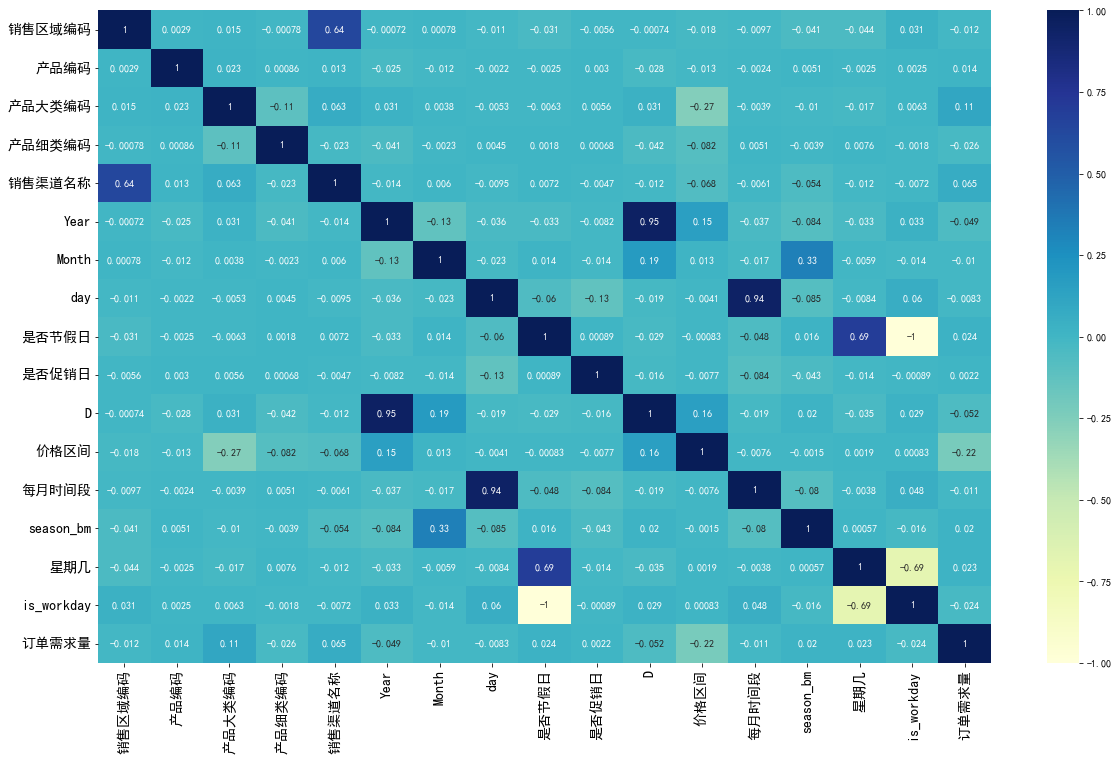

In [124]:
plt.rcParams['font.sans-serif'] = ['SimHei']
# 选择需要分析的特征列和订单需求量列

df = pd.read_csv('data/proess_transform.csv')

# 选择需要分析的特征列和订单需求量列
target_col = '订单需求量'
feature_cols = [col for col in df.columns if col != target_col]

# 计算相关系数
corr = df[feature_cols + [target_col]].corr()

# 绘制热力图
plt.figure(figsize=(20, 12))
ax = sns.heatmap(corr, annot=True, cmap='YlGnBu')

# 设置x轴和y轴标签的字体大小
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.savefig("热力图.jpg",dpi=300)
plt.show()

In [45]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,0,59,2018,12,20,0,0,1207,3,1,3,3,1
597378,2018-12-20,102,21875,302,408,0,502,2018,12,20,0,0,1207,2,1,3,3,1
597379,2018-12-20,102,20215,302,408,0,106,2018,12,20,0,0,1207,6,1,3,3,1
597380,2018-12-20,102,20195,302,408,0,187,2018,12,20,0,0,1207,6,1,3,3,1


In [46]:
##剔除掉大于等于1202天的数据，因为验证的时候，构造的数据时1202天开始的，避免重复值，我们在df中先删除掉

df = df[df['D']<1202]
df 

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592916,2018-12-14,103,21492,306,407,0,10,2018,12,14,0,0,1201,5,1,3,4,1
592917,2018-12-14,103,21415,305,412,0,152,2018,12,14,0,0,1201,2,1,3,4,1
592918,2018-12-14,103,20215,302,408,0,6,2018,12,14,0,0,1201,6,1,3,4,1
592919,2018-12-14,103,20321,302,408,0,5,2018,12,14,0,0,1201,5,1,3,4,1


In [47]:
#拼接df_sub和df：

df1 =pd.concat([df,df_sub],axis=0)
df1

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1
245228,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1
245229,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1
245230,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1


In [48]:
df=df1
df = df.reset_index(drop=True)
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1
838128,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1
838129,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1
838130,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1


# 特征工程

## 滞后特征

滞后特征是将时间序列预测问题转化为监督学习问题的经典方法。

对销售的目标变量引入滞后。我使用的最大延迟是60天。这完全取决于你想引入多少滞后。

In [49]:
s = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码',],as_index=False)['订单需求量'].shift(60)
s 

,订单需求量
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
838127,NaN
838128,53.0
838129,NaN
838130,NaN


In [50]:
#Introduce lags
lags = [1,2,3,6,12,24,36,48,60]
for lag in lags:
    df['need_lag_'+str(lag)] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码',],as_index=False)['订单需求量'].shift(lag).astype(np.float16)

In [51]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN
838128,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0
838129,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN
838130,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN


## 均值编码

从数学的角度来看，均值编码表示目标变量的概率，条件是特征的每个值。在某种程度上，它将目标变量体现在其编码值中。我根据我能想到的以下逻辑特征计算出了平均编码:-

In [52]:
s =  df.groupby('产品编码')['订单需求量'].transform('mean')
s

0          12.285714
1           0.925926
2         115.556748
3          73.055866
4          10.714286
             ...    
838127      1.966825
838128     16.049669
838129      0.790476
838130      0.274510
838131      1.950450
Name: 订单需求量, Length: 838132, dtype: float64

In [53]:
df['产品编码_avg'] = df.groupby('产品编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_need_avg'] = df.groupby('销售区域编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_need_avg'] = df.groupby('产品大类编码')['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_need_avg'] = df.groupby('产品细类编码')['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_need_avg'] = df.groupby('销售渠道名称')['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品编码_need_avg'] = df.groupby(['产品编码','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品编码_need_avg'] = df.groupby(['产品大类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品细类编码_产品编码_need_avg'] = df.groupby(['产品细类编码','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品编码_need_avg'] = df.groupby(['销售渠道名称','产品编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售区域编码_产品大类编码_need_avg'] = df.groupby(['销售区域编码','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['产品大类编码_产品细类编码_need_avg'] = df.groupby(['产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['销售渠道名称_产品细类编码_need_avg'] = df.groupby(['销售渠道名称','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)



df['年_月_need_avg'] = df.groupby(['Year','Month'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售区域编码_need_avg'] = df.groupby(['Year','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品大类编码_need_avg'] = df.groupby(['Year','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_产品细类编码_need_avg'] = df.groupby(['Year','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['年_销售渠道名称_need_avg'] = df.groupby(['Year','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['月_销售区域编码_need_avg'] = df.groupby(['Month','销售区域编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品大类编码_need_avg'] = df.groupby(['Month','产品大类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_产品细类编码_need_avg'] = df.groupby(['Month','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['月_销售渠道名称_need_avg'] = df.groupby(['Month','销售渠道名称'])['订单需求量'].transform('mean').astype(np.float16)


df['每月时间段_销售区域编码_need_avg'] = df.groupby(['销售区域编码','每月时间段'])['订单需求量'].transform('mean').astype(np.float16)

df['价格区间_销售区域编码_need_avg'] = df.groupby(['销售区域编码','价格区间'])['订单需求量'].transform('mean').astype(np.float16)

In [54]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,80.50000,80.50000,58.8125,12.289062,12.289062,12.289062,12.664062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.925781,94.5625,60.96875,60.96875,58.8125,9.000000,0.925781,0.925781,0.925781,86.812500,60.96875,36.25000,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.562500,94.5625,80.50000,80.50000,82.1250,130.125000,115.562500,115.562500,133.250000,102.875000,80.50000,89.43750,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.062500,94.5625,84.12500,84.12500,82.1250,100.500000,73.062500,73.062500,73.062500,102.500000,84.12500,92.50000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,80.50000,80.50000,58.8125,10.710938,10.710938,10.710938,12.164062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.12500,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.62500,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250
838128,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.06250,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.87500,0.0000,0.0000,0.0000,0.0000,0.00,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250
838129,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.12500,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.15625,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375
838130,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.12500,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000


## 滑动窗口统计

我将计算每周销售的滚动平均数。更多的特征，如滚动最小值，最大值或总和也可以计算。同样，同样的功能也可以用于计算需求量。

In [55]:
df['rolling_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [56]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,80.50000,80.50000,58.8125,12.289062,12.289062,12.289062,12.664062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250,NaN
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.925781,94.5625,60.96875,60.96875,58.8125,9.000000,0.925781,0.925781,0.925781,86.812500,60.96875,36.25000,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250,NaN
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.562500,94.5625,80.50000,80.50000,82.1250,130.125000,115.562500,115.562500,133.250000,102.875000,80.50000,89.43750,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500,NaN
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.062500,94.5625,84.12500,84.12500,82.1250,100.500000,73.062500,73.062500,73.062500,102.500000,84.12500,92.50000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500,NaN
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,80.50000,80.50000,58.8125,10.710938,10.710938,10.710938,12.164062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.12500,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.62500,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250,0.0
838128,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.06250,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.87500,0.0000,0.0000,0.0000,0.0000,0.00,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250,0.0
838129,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.12500,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.15625,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375,0.0
838130,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.12500,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000,0.0


## 开窗数据拓展

这是滚动窗口技术的高级版本。在滚动窗口的情况下，当窗口随着时间向前移动而滑动时，窗口的大小是恒定的。因此，我们只考虑最近的值，而忽略过去的值。
我将计算需求量的扩大平均值。还可以计算更多的特征，如扩展最小值、最大值或总和。同样，同样的功能也可以用于计算需求量。

In [57]:
df['expanding_need_mean'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [58]:
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean
0,2015-09-01,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,80.50000,80.50000,58.8125,12.289062,12.289062,12.289062,12.664062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250,NaN,NaN
1,2015-09-01,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.925781,94.5625,60.96875,60.96875,58.8125,9.000000,0.925781,0.925781,0.925781,86.812500,60.96875,36.25000,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250,NaN,NaN
2,2015-09-02,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.562500,94.5625,80.50000,80.50000,82.1250,130.125000,115.562500,115.562500,133.250000,102.875000,80.50000,89.43750,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500,NaN,NaN
3,2015-09-02,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.062500,94.5625,84.12500,84.12500,82.1250,100.500000,73.062500,73.062500,73.062500,102.500000,84.12500,92.50000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500,NaN,NaN
4,2015-09-02,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,80.50000,80.50000,58.8125,10.710938,10.710938,10.710938,12.164062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.12500,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.62500,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250,0.0,0.568848
838128,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.06250,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.87500,0.0000,0.0000,0.0000,0.0000,0.00,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250,0.0,21.968750
838129,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.12500,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.15625,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375,0.0,0.320068
838130,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.12500,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000,0.0,0.102051


## 需求量趋势构建

我将创建一个需求量趋势特征，如果每日需求量大于整个持续时间的平均值(d_1 - d_1206)，则为负值。可以添加更多的趋势特性，但我只添加这一个以保持简单。

In [59]:
df['daily_avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码','D'])['订单需求量'].transform('mean').astype(np.float16)
df['avg_need'] = df.groupby(['销售区域编码','产品编码','产品大类编码','产品细类编码'])['订单需求量'].transform('mean').astype(np.float16)
df['need_trend'] = (df['daily_avg_need'] - df['avg_need']).astype(np.float16)
df.drop(['daily_avg_need','avg_need'],axis=1,inplace=True)

In [60]:

df.drop('订单日期',axis=1,inplace=True)
df

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,104,22069,307,403,0,19,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.289062,94.5625,80.50000,80.50000,58.8125,12.289062,12.289062,12.289062,12.664062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,61.281250,NaN,NaN,6.710938
1,104,20028,301,405,0,12,2015,9,1,0,0,1,4,0,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.925781,94.5625,60.96875,60.96875,58.8125,9.000000,0.925781,0.925781,0.925781,86.812500,60.96875,36.25000,107.6875,111.0625,84.4375,84.4375,106.00,103.750000,70.437500,70.437500,73.875000,92.62500,61.281250,NaN,NaN,3.000000
2,104,21183,307,403,1,109,2015,9,2,0,0,2,0,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.562500,94.5625,80.50000,80.50000,82.1250,130.125000,115.562500,115.562500,133.250000,102.875000,80.50000,89.43750,107.6875,111.0625,116.6250,116.6250,153.25,103.750000,110.750000,110.750000,123.875000,92.62500,120.187500,NaN,NaN,-21.125000
3,104,20448,308,404,1,3,2015,9,2,0,0,2,3,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.062500,94.5625,84.12500,84.12500,82.1250,100.500000,73.062500,73.062500,73.062500,102.500000,84.12500,92.50000,107.6875,111.0625,138.2500,138.2500,153.25,103.750000,98.562500,98.562500,123.875000,92.62500,91.687500,NaN,NaN,-97.500000
4,104,21565,307,403,0,3,2015,9,2,0,0,2,5,0,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.710938,94.5625,80.50000,80.50000,58.8125,10.710938,10.710938,10.710938,12.164062,102.875000,80.50000,75.25000,107.6875,111.0625,116.6250,116.6250,106.00,103.750000,110.750000,110.750000,73.875000,92.62500,68.187500,NaN,NaN,-7.710938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.12500,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.62500,0.0000,0.0000,0.0000,0.0000,0.00,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250,0.0,0.568848,-0.568848
838128,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.06250,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.87500,0.0000,0.0000,0.0000,0.0000,0.00,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250,0.0,21.968750,-21.968750
838129,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.12500,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.15625,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375,0.0,0.320068,-0.320068
838130,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.12500,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.93750,0.0000,0.0000,0.0000,0.0000,0.00,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000,0.0,0.102051,-0.102051


## 保存数据

现在，既然已经创建了所有新特征，让我们保存数据，以便分别对其进行训练。
此外，延迟引入了许多Null值，因此我将删除前60天的数据，因为我已经引入了到60天的延迟。

In [61]:
df = df[df['D']>=60]
df 

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
14994,102,22047,306,407,0,99,2015,10,30,0,0,60,4,2,2,4,1,52.0,46.0,152.0,13.0,55.0,13.0,18.0,25.0,NaN,50.125000,62.4375,83.1250,78.56250,58.8125,49.468750,50.125000,50.125000,51.750000,88.937500,78.56250,75.93750,111.9375,102.250,155.75,143.75,106.0,79.812500,131.625000,121.312500,77.250000,56.93750,42.812500,63.71875,52.218750,49.531250
14995,103,21469,302,408,0,47,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.750000,66.0625,41.4375,41.43750,58.8125,23.984375,98.750000,98.750000,99.125000,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,103.687500,NaN,NaN,23.015625
14996,103,21295,302,408,0,10,2015,10,30,0,0,60,2,2,2,4,1,201.0,107.0,28.0,47.0,101.0,431.0,208.0,NaN,NaN,74.562500,66.0625,41.4375,41.43750,58.8125,113.562500,74.562500,74.562500,79.312500,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,76.375000,91.00000,123.187500,-55.562500
14997,103,20765,302,408,0,46,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.984375,66.0625,41.4375,41.43750,58.8125,14.625000,23.984375,23.984375,28.218750,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,103.687500,NaN,NaN,31.375000
14998,103,20591,302,408,0,33,2015,10,30,0,0,60,1,2,2,4,1,21.0,16.0,72.0,32.0,45.0,NaN,NaN,NaN,NaN,87.937500,66.0625,41.4375,41.43750,58.8125,65.875000,87.937500,87.937500,97.687500,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,115.125000,37.43750,118.562500,-34.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.1250,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.62500,0.0000,0.000,0.00,0.00,0.0,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250,0.00000,0.568848,-0.568848
838128,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.0625,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.87500,0.0000,0.000,0.00,0.00,0.0,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250,0.00000,21.968750,-21.968750
838129,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.1250,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.15625,0.0000,0.000,0.00,0.00,0.0,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375,0.00000,0.320068,-0.320068
838130,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.1250,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.93750,0.0000,0.000,0.00,0.00,0.0,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000,0.00000,0.102051,-0.102051


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 823138 entries, 14994 to 838131
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   销售区域编码                  823138 non-null  int64  
 1   产品编码                    823138 non-null  int64  
 2   产品大类编码                  823138 non-null  int64  
 3   产品细类编码                  823138 non-null  int64  
 4   销售渠道名称                  823138 non-null  int64  
 5   订单需求量                   823138 non-null  int64  
 6   Year                    823138 non-null  int64  
 7   Month                   823138 non-null  int64  
 8   day                     823138 non-null  int64  
 9   是否节假日                   823138 non-null  int64  
 10  是否促销日                   823138 non-null  int64  
 11  D                       823138 non-null  int64  
 12  价格区间                    823138 non-null  int64  
 13  每月时间段                   823138 non-null  int64  
 14  season_bm       

In [63]:
df.to_pickle('data4_5.pkl')
del df


In [64]:
#df2 = df[df['D']<1202]
#df2.to_csv('data4_5_1.csv')
#df1.to_csv('data4_5_2.csv')

# 建立模型

In [65]:
data = pd.read_pickle('data4_5.pkl')
data

data = data.reset_index(drop=True)
data

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,102,22047,306,407,0,99,2015,10,30,0,0,60,4,2,2,4,1,52.0,46.0,152.0,13.0,55.0,13.0,18.0,25.0,NaN,50.125000,62.4375,83.1250,78.56250,58.8125,49.468750,50.125000,50.125000,51.750000,88.937500,78.56250,75.93750,111.9375,102.250,155.75,143.75,106.0,79.812500,131.625000,121.312500,77.250000,56.93750,42.812500,63.71875,52.218750,49.531250
1,103,21469,302,408,0,47,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.750000,66.0625,41.4375,41.43750,58.8125,23.984375,98.750000,98.750000,99.125000,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,103.687500,NaN,NaN,23.015625
2,103,21295,302,408,0,10,2015,10,30,0,0,60,2,2,2,4,1,201.0,107.0,28.0,47.0,101.0,431.0,208.0,NaN,NaN,74.562500,66.0625,41.4375,41.43750,58.8125,113.562500,74.562500,74.562500,79.312500,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,76.375000,91.00000,123.187500,-55.562500
3,103,20765,302,408,0,46,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.984375,66.0625,41.4375,41.43750,58.8125,14.625000,23.984375,23.984375,28.218750,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,103.687500,NaN,NaN,31.375000
4,103,20591,302,408,0,33,2015,10,30,0,0,60,1,2,2,4,1,21.0,16.0,72.0,32.0,45.0,NaN,NaN,NaN,NaN,87.937500,66.0625,41.4375,41.43750,58.8125,65.875000,87.937500,87.937500,97.687500,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,115.125000,37.43750,118.562500,-34.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823133,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.1250,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.62500,0.0000,0.000,0.00,0.00,0.0,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250,0.00000,0.568848,-0.568848
823134,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.0625,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.87500,0.0000,0.000,0.00,0.00,0.0,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250,0.00000,21.968750,-21.968750
823135,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.1250,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.15625,0.0000,0.000,0.00,0.00,0.0,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375,0.00000,0.320068,-0.320068
823136,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.1250,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.93750,0.0000,0.000,0.00,0.00,0.0,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000,0.00000,0.102051,-0.102051


In [66]:
data[data['D']>=1202]

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
577906,101,20901,303,410,1,0,2018,12,15,1,0,1202,3,1,3,5,0,15.0,28.0,11.0,13.0,13.0,35.0,10.0,29.0,17.0,10.671875,65.3125,34.1250,8.00000,82.1250,13.359375,10.671875,10.671875,0.489746,32.687500,8.00000,0.563965,6.878906,55.84375,32.43750,10.046875,82.31250,36.562500,15.718750,2.589844,35.031250,65.25000,52.718750,12.429688,16.765625,-13.359375
577907,103,21993,302,408,0,0,2018,12,15,1,0,1202,6,1,3,5,0,15.0,7.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,1.950195,66.0625,41.4375,41.43750,58.8125,2.191406,1.950195,1.950195,1.950195,51.500000,41.43750,34.687500,6.878906,57.68750,33.71875,33.718750,47.59375,38.687500,21.343750,21.343750,37.968750,66.87500,17.156250,NaN,22.796875,-2.191406
577908,105,20047,308,404,0,0,2018,12,15,1,0,1202,3,1,3,5,0,157.0,153.0,203.0,194.0,NaN,NaN,NaN,NaN,NaN,18.453125,62.5000,84.1250,84.12500,58.8125,15.296875,18.453125,18.453125,18.453125,70.437500,84.12500,79.812500,6.878906,58.84375,78.43750,78.437500,47.59375,26.296875,54.187500,54.187500,37.968750,65.00000,67.437500,118.000000,118.000000,-15.296875
577909,105,22027,306,402,1,0,2018,12,15,1,0,1202,0,1,3,5,0,7.0,11.0,5.0,10.0,12.0,28.0,4.0,12.0,54.0,21.578125,62.5000,83.1250,172.75000,82.1250,35.625000,21.578125,21.578125,38.093750,73.812500,172.75000,221.125000,6.878906,58.84375,70.62500,115.375000,82.31250,26.296875,52.031250,153.625000,35.031250,65.00000,113.937500,7.429688,54.031250,-35.625000
577910,102,20445,303,401,1,0,2018,12,15,1,0,1202,1,1,3,5,0,114.0,500.0,236.0,209.0,88.0,24.0,75.0,28.0,69.0,144.250000,62.4375,34.1250,40.46875,82.1250,83.500000,144.250000,144.250000,136.250000,25.937500,40.46875,58.718750,6.878906,52.87500,32.43750,40.343750,82.31250,43.625000,15.718750,19.125000,35.031250,62.90625,111.125000,191.625000,131.875000,-83.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823133,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.1250,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.625000,0.000000,0.00000,0.00000,0.000000,0.00000,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250,0.000000,0.568848,-0.568848
823134,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.0625,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.875000,0.000000,0.00000,0.00000,0.000000,0.00000,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250,0.000000,21.968750,-21.968750
823135,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.1250,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.156250,0.000000,0.00000,0.00000,0.000000,0.00000,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375,0.000000,0.320068,-0.320068
823136,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.1250,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.937500,0.000000,0.00000,0.00000,0.000000,0.00000,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000,0.000000,0.102051,-0.102051


In [67]:
data = pd.read_pickle('data4_5.pkl')
valid = data[(data['D']>=1176) & (data['D']<1202)][['产品编码','D','订单需求量']]
test = data[data['D']>=1202][['产品编码','D','订单需求量']]   #作为待预测的数据
eval_preds = test['订单需求量']    ## 待预测 目前全为0
valid_preds = valid['订单需求量']  #这是已有真实标签需求量1175到1206，31天间隔的真实数据

In [68]:
eval_preds

trues = eval_preds[:500]
trues

592900    0
592901    0
592902    0
592903    0
592904    0
         ..
593395    0
593396    0
593397    0
593398    0
593399    0
Name: 订单需求量, Length: 500, dtype: int64

In [69]:
valid_preds

570387     10
570388      7
570389      8
570390      6
570391      6
         ... 
592895     10
592896    152
592897      6
592898      5
592899     27
Name: 订单需求量, Length: 22513, dtype: int64

In [70]:

states = list(set(data['销售区域编码']))
states

[101, 102, 103, 104, 105]

## 建立每个销售区域的模型

这里报错是因为销售区域104，数据量太少无法进行构建足够数据去训练预测，相信等完整数据发布后，将能预测运行，我们现在先进行跳过对104建模处理

In [71]:
# 画出损失函数的变化情况
def plot_logloss(model,model_name):
    plt.figure(figsize=(10, 5))
    results = model.evals_result_
#     print(results)
    epochs = len(results['training']['rmse'])
    x_axis = range(0, epochs)
#     print(epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['rmse'], label='Train')
#     print(results['validation_1']['logloss'])
    ax.plot(x_axis, results['valid_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('{}LGBMRegressor rmse'.format(model_name))
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['training']['mape'], label='Train')
    ax.plot(x_axis, results['valid_1']['mape'], label='Test')
    ax.legend()
    plt.ylabel('mape')
    plt.title('{}LGBMRegressor mape'.format(model_name))
    plt.show()

In [72]:
data

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
14994,102,22047,306,407,0,99,2015,10,30,0,0,60,4,2,2,4,1,52.0,46.0,152.0,13.0,55.0,13.0,18.0,25.0,NaN,50.125000,62.4375,83.1250,78.56250,58.8125,49.468750,50.125000,50.125000,51.750000,88.937500,78.56250,75.93750,111.9375,102.250,155.75,143.75,106.0,79.812500,131.625000,121.312500,77.250000,56.93750,42.812500,63.71875,52.218750,49.531250
14995,103,21469,302,408,0,47,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.750000,66.0625,41.4375,41.43750,58.8125,23.984375,98.750000,98.750000,99.125000,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,103.687500,NaN,NaN,23.015625
14996,103,21295,302,408,0,10,2015,10,30,0,0,60,2,2,2,4,1,201.0,107.0,28.0,47.0,101.0,431.0,208.0,NaN,NaN,74.562500,66.0625,41.4375,41.43750,58.8125,113.562500,74.562500,74.562500,79.312500,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,76.375000,91.00000,123.187500,-55.562500
14997,103,20765,302,408,0,46,2015,10,30,0,0,60,0,2,2,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.984375,66.0625,41.4375,41.43750,58.8125,14.625000,23.984375,23.984375,28.218750,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,103.687500,NaN,NaN,31.375000
14998,103,20591,302,408,0,33,2015,10,30,0,0,60,1,2,2,4,1,21.0,16.0,72.0,32.0,45.0,NaN,NaN,NaN,NaN,87.937500,66.0625,41.4375,41.43750,58.8125,65.875000,87.937500,87.937500,97.687500,51.500000,41.43750,34.68750,111.9375,105.125,83.50,83.50,106.0,96.625000,78.562500,78.562500,77.250000,60.25000,115.125000,37.43750,118.562500,-34.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838127,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,1.966797,66.0625,34.1250,40.46875,58.8125,0.568848,1.966797,1.966797,1.698242,43.000000,40.46875,36.62500,0.0000,0.000,0.00,0.00,0.0,25.531250,11.328125,13.976562,25.359375,60.25000,17.156250,0.00000,0.568848,-0.568848
838128,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,53.0,16.046875,62.4375,60.0625,60.06250,58.8125,21.968750,16.046875,16.046875,16.046875,53.906250,60.06250,53.87500,0.0000,0.000,0.00,0.00,0.0,27.390625,22.812500,22.812500,25.359375,56.93750,56.406250,0.00000,21.968750,-21.968750
838129,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.790527,65.3125,34.1250,8.00000,58.8125,0.320068,0.790527,0.790527,0.790527,32.687500,8.00000,8.15625,0.0000,0.000,0.00,0.00,0.0,25.375000,11.328125,1.717773,25.359375,60.28125,17.109375,0.00000,0.320068,-0.320068
838130,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,NaN,0.274414,65.3125,83.1250,78.56250,58.8125,0.102051,0.274414,0.274414,0.274414,83.562500,78.56250,75.93750,0.0000,0.000,0.00,0.00,0.0,25.375000,35.875000,32.781250,25.359375,60.28125,44.750000,0.00000,0.102051,-0.102051


183160
*****Prediction for 销售区域: 101*****
[10]	training's rmse: 106.931	training's mape: 1.57003	training's l2: 11434.2	valid_1's rmse: 87.2712	valid_1's mape: 2.27083	valid_1's l2: 7616.26
[20]	training's rmse: 101.867	training's mape: 1.39102	training's l2: 10377	valid_1's rmse: 84.209	valid_1's mape: 2.02925	valid_1's l2: 7091.15
[30]	training's rmse: 99.2323	training's mape: 1.33272	training's l2: 9847.05	valid_1's rmse: 83.4294	valid_1's mape: 1.95465	valid_1's l2: 6960.46
[40]	training's rmse: 97.293	training's mape: 1.31432	training's l2: 9465.93	valid_1's rmse: 82.4852	valid_1's mape: 1.94597	valid_1's l2: 6803.81
[50]	training's rmse: 95.5677	training's mape: 1.3032	training's l2: 9133.18	valid_1's rmse: 82.035	valid_1's mape: 1.92213	valid_1's l2: 6729.74
[60]	training's rmse: 94.3116	training's mape: 1.29663	training's l2: 8894.68	valid_1's rmse: 81.7778	valid_1's mape: 1.92354	valid_1's l2: 6687.61
[70]	training's rmse: 93.2037	training's mape: 1.28986	training's l2: 8686.9

<Figure size 720x360 with 0 Axes>

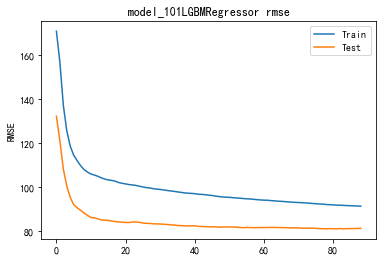

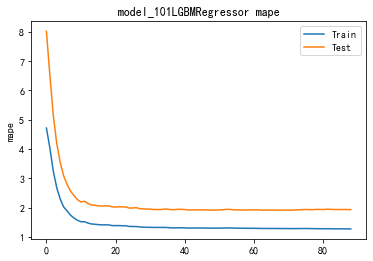

217935
*****Prediction for 销售区域: 102*****
[10]	training's rmse: 82.1708	training's mape: 1.37362	training's l2: 6752.04	valid_1's rmse: 68.7508	valid_1's mape: 1.73758	valid_1's l2: 4726.67
[20]	training's rmse: 77.6924	training's mape: 1.21146	training's l2: 6036.11	valid_1's rmse: 64.0811	valid_1's mape: 1.52985	valid_1's l2: 4106.39
[30]	training's rmse: 75.5431	training's mape: 1.18285	training's l2: 5706.75	valid_1's rmse: 62.1724	valid_1's mape: 1.50225	valid_1's l2: 3865.41
[40]	training's rmse: 74.0135	training's mape: 1.16025	training's l2: 5478	valid_1's rmse: 60.9323	valid_1's mape: 1.49129	valid_1's l2: 3712.75
[50]	training's rmse: 73.0464	training's mape: 1.14975	training's l2: 5335.78	valid_1's rmse: 59.7788	valid_1's mape: 1.48644	valid_1's l2: 3573.51
[60]	training's rmse: 72.3218	training's mape: 1.14434	training's l2: 5230.44	valid_1's rmse: 59.0285	valid_1's mape: 1.48733	valid_1's l2: 3484.36
[70]	training's rmse: 71.5523	training's mape: 1.13236	training's l2: 511

<Figure size 720x360 with 0 Axes>

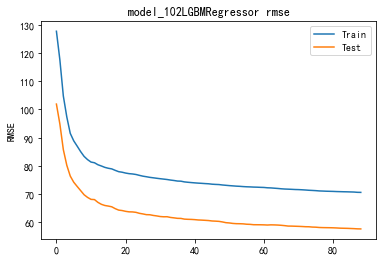

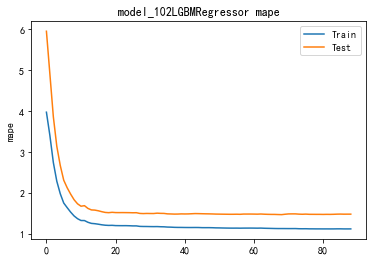

169722
*****Prediction for 销售区域: 103*****
[10]	training's rmse: 105.805	training's mape: 1.52915	training's l2: 11194.7	valid_1's rmse: 118.028	valid_1's mape: 2.52264	valid_1's l2: 13930.7
[20]	training's rmse: 101.101	training's mape: 1.39261	training's l2: 10221.4	valid_1's rmse: 113.311	valid_1's mape: 2.31909	valid_1's l2: 12839.3
[30]	training's rmse: 98.0245	training's mape: 1.33613	training's l2: 9608.8	valid_1's rmse: 111.365	valid_1's mape: 2.25422	valid_1's l2: 12402.3
[40]	training's rmse: 96.1783	training's mape: 1.32966	training's l2: 9250.27	valid_1's rmse: 110.01	valid_1's mape: 2.27971	valid_1's l2: 12102.2
[50]	training's rmse: 94.8156	training's mape: 1.32183	training's l2: 8989.99	valid_1's rmse: 109.112	valid_1's mape: 2.28576	valid_1's l2: 11905.5


<Figure size 720x360 with 0 Axes>

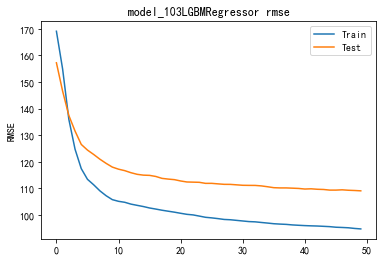

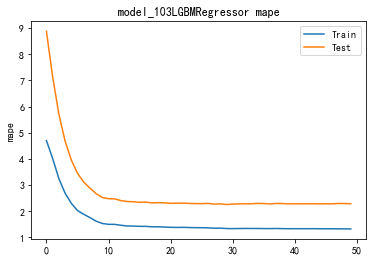

23229
*****Prediction for 销售区域: 104*****
229092
*****Prediction for 销售区域: 105*****
[10]	training's rmse: 99.8972	training's mape: 1.68286	training's l2: 9979.44	valid_1's rmse: 106.052	valid_1's mape: 1.86353	valid_1's l2: 11247
[20]	training's rmse: 94.4345	training's mape: 1.51637	training's l2: 8917.87	valid_1's rmse: 102.475	valid_1's mape: 1.69081	valid_1's l2: 10501.1
[30]	training's rmse: 91.7853	training's mape: 1.46446	training's l2: 8424.53	valid_1's rmse: 100.509	valid_1's mape: 1.63822	valid_1's l2: 10102
[40]	training's rmse: 89.9139	training's mape: 1.44815	training's l2: 8084.51	valid_1's rmse: 99.8086	valid_1's mape: 1.64087	valid_1's l2: 9961.75


<Figure size 720x360 with 0 Axes>

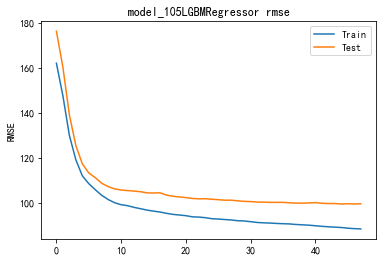

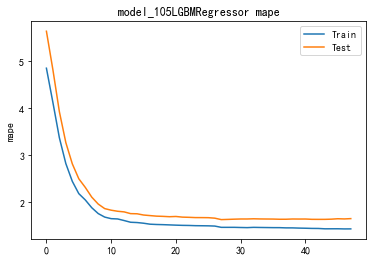

In [73]:

for store in states:
    try:
        df = data[data['销售区域编码']==store]
        print(len(df))

        #Split the data
        X_train, y_train = df[df['D']<1176].drop('订单需求量',axis=1), df[df['D']<1176]['订单需求量']
        X_valid, y_valid = df[(df['D']>=1176) & (df['D']<1202)].drop('订单需求量',axis=1), df[(df['D']>=1176) & (df['D']<1202)]['订单需求量']
        X_test = df[df['D']>=1202].drop('订单需求量',axis=1)

        #Train and validate
        model = LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.3,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            num_leaves=50,
            min_child_weight=300
        )
        print('*****Prediction for 销售区域: {}*****'.format(store))
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
                 eval_metric='rmse,mape', verbose=10, early_stopping_rounds=20)
        valid_preds[X_valid.index] = model.predict(X_valid)
        eval_preds[X_test.index] = model.predict(X_test)
        filename = "models/" + "model_"+ str(store) + ".pkl"
        # save model
        joblib.dump(model, filename)
#         print("ces:",model.evals_result_)
        plot_logloss(model,"model_"+ str(store))
   
        del model, X_train, y_train, X_valid, y_valid
    except:
        del model, X_train, y_train, X_valid, y_valid
        continue

## 挑选出101区域的模型进行模型验证：

In [74]:
model = joblib.load("models/model_102.pkl")
model

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=8,
              min_child_weight=300, n_estimators=1000, num_leaves=50,
              subsample=0.8)

In [75]:
df = data[data['销售区域编码']==102]
X_valid, y_valid = df[(df['D']>=1176) & (df['D']<1202)].drop('订单需求量',axis=1), df[(df['D']>=1176) & (df['D']<1202)]['订单需求量']
y_valid

570429     14
570438     55
570440     53
570441    106
570442    233
         ... 
592804     34
592805     49
592831    351
592866     65
592867     12
Name: 订单需求量, Length: 5290, dtype: int64

In [76]:
X_valid

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,年_月_need_avg,年_销售区域编码_need_avg,年_产品大类编码_need_avg,年_产品细类编码_need_avg,年_销售渠道名称_need_avg,月_销售区域编码_need_avg,月_产品大类编码_need_avg,月_产品细类编码_need_avg,月_销售渠道名称_need_avg,每月时间段_销售区域编码_need_avg,价格区间_销售区域编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
570429,102,20892,306,407,0,2018,11,19,0,0,1176,6,1,2,0,1,11.0,5.0,3.0,6.0,13.0,7.0,11.0,2.0,11.0,13.375000,62.4375,83.12500,78.56250,58.8125,11.046875,13.375000,13.375000,13.578125,88.93750,78.56250,75.93750,66.500000,52.875,70.62500,68.312500,47.59375,83.1875,106.06250,96.375000,79.68750,62.90625,13.148438,6.570312,14.921875,2.953125
570438,102,21501,306,407,0,2018,11,19,0,0,1176,3,1,2,0,1,106.0,28.0,177.0,199.0,13.0,28.0,NaN,NaN,NaN,21.921875,62.4375,83.12500,78.56250,58.8125,41.906250,21.921875,21.921875,21.921875,88.93750,78.56250,75.93750,66.500000,52.875,70.62500,68.312500,47.59375,83.1875,106.06250,96.375000,79.68750,62.90625,56.406250,134.250000,72.562500,35.406250
570440,102,20321,302,408,0,2018,11,19,0,0,1176,4,1,2,0,1,3.0,69.0,4.0,233.0,29.0,10.0,3.0,28.0,7.0,15.281250,62.4375,41.43750,41.43750,58.8125,14.406250,15.281250,15.281250,15.281250,36.78125,41.43750,34.68750,66.500000,52.875,33.71875,33.718750,47.59375,83.1875,50.34375,50.343750,79.68750,62.90625,42.812500,53.718750,18.359375,32.593750
570441,102,20478,302,408,0,2018,11,19,0,0,1176,4,1,2,0,1,151.0,13.0,124.0,9.0,16.0,32.0,7.0,178.0,NaN,27.812500,62.4375,41.43750,41.43750,58.8125,31.093750,27.812500,27.812500,27.812500,36.78125,41.43750,34.68750,66.500000,52.875,33.71875,33.718750,47.59375,83.1875,50.34375,50.343750,79.68750,62.90625,42.812500,115.875000,57.343750,74.875000
570442,102,21394,306,407,0,2018,11,19,0,0,1176,2,1,2,0,1,49.0,484.0,488.0,207.0,1009.0,206.0,25.0,309.0,157.0,146.250000,62.4375,83.12500,78.56250,58.8125,182.750000,146.250000,146.250000,146.875000,88.93750,78.56250,75.93750,66.500000,52.875,70.62500,68.312500,47.59375,83.1875,106.06250,96.375000,79.68750,62.90625,87.437500,430.250000,191.500000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592804,102,21779,307,403,0,2018,12,14,0,0,1201,2,1,3,4,1,302.0,10.0,254.0,2.0,14.0,204.0,22.0,142.0,55.0,76.125000,62.4375,80.50000,80.50000,58.8125,92.875000,76.125000,76.125000,76.250000,75.12500,80.50000,75.25000,6.878906,52.875,79.62500,79.625000,47.59375,43.6250,50.68750,50.687500,37.96875,62.90625,87.437500,101.562500,99.437500,75.125000
592805,102,20525,301,405,0,2018,12,14,0,0,1201,3,1,3,4,1,21.0,10.0,41.0,16.0,3.0,470.0,64.0,6.0,39.0,54.093750,62.4375,60.96875,60.96875,58.8125,67.250000,54.093750,54.093750,54.156250,46.00000,60.96875,36.25000,6.878906,52.875,52.87500,52.875000,47.59375,43.6250,34.43750,34.437500,37.96875,62.90625,56.406250,36.718750,73.562500,-40.562500
592831,102,20504,307,403,0,2018,12,14,0,0,1201,0,1,3,4,1,251.0,108.0,28.0,8.0,16.0,26.0,17.0,21.0,301.0,82.125000,62.4375,80.50000,80.50000,58.8125,104.312500,82.125000,82.125000,100.000000,75.12500,80.50000,75.25000,6.878906,52.875,79.62500,79.625000,47.59375,43.6250,50.68750,50.687500,37.96875,62.90625,96.312500,115.437500,116.312500,196.750000
592866,102,20588,302,408,0,2018,12,14,0,0,1201,5,1,3,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.687500,62.4375,41.43750,41.43750,58.8125,1.326172,11.687500,11.687500,11.687500,36.78125,41.43750,34.68750,6.878906,52.875,33.71875,33.718750,47.59375,43.6250,21.34375,21.343750,37.96875,62.90625,30.203125,NaN,NaN,63.687500


In [77]:
s = model.predict(X_valid)
s

array([ 12.27495222,  81.28457722,  38.46685833, ..., 254.78104516,
        57.83640196,  15.91282185])

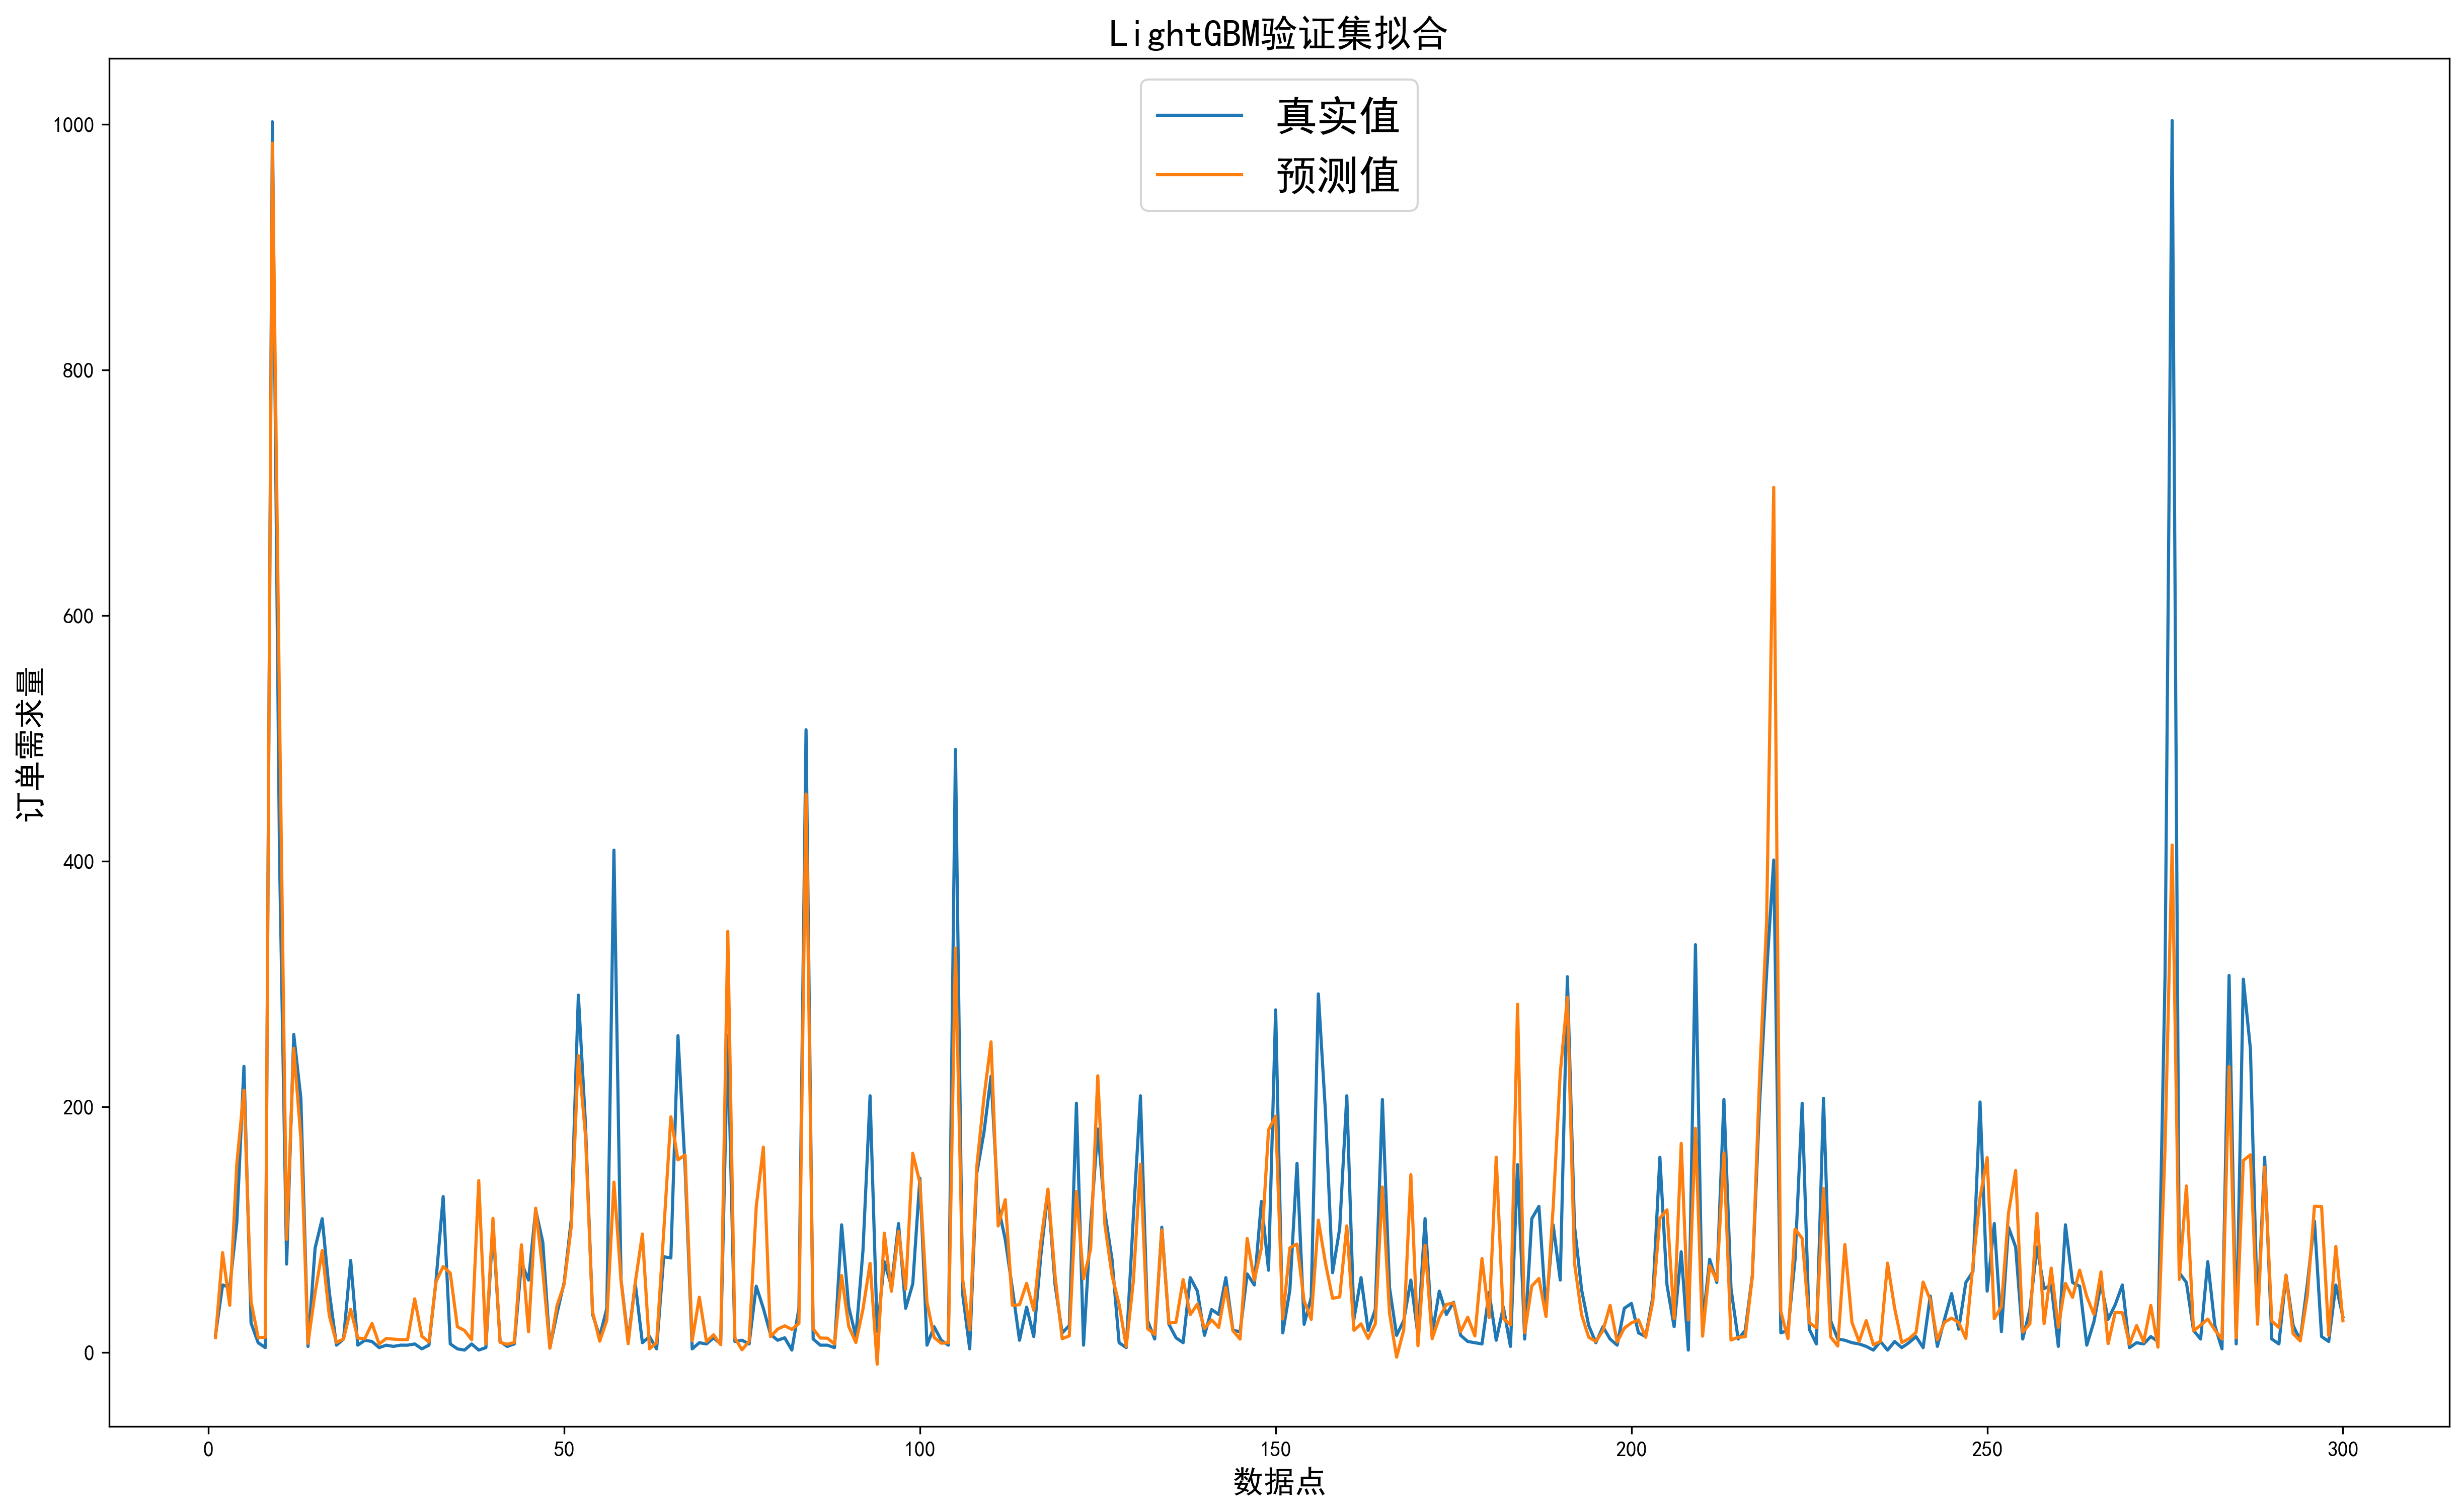

In [78]:
x_axis=np.linspace(1,len(y_valid),len(y_valid))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(20,12))

plt.title('LightGBM验证集拟合',fontsize=18)
plt.xlabel('数据点',fontsize=15)
plt.ylabel('订单需求量',fontsize=15)
plt.plot(x_axis[:300],y_valid[:300])
plt.plot(x_axis[:300],s[:300])
plt.legend(['真实值','预测值'],prop = {'size':20})
plt.savefig('LightGBM.jpg',fontsize=18)
plt.show()
# plt.scatter(x_data,y_data_yuemo,color='blue')
#plt.tick_params(labelsize=20)  #修改刻度显示大小

In [79]:
# x_axis=np.linspace(1,len(y_valid),len(y_valid))
# font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
# colors =['black','green','yellow','blue','cyan','red','orange','pink']
# plt.figure(dpi=300,figsize=(20,12))

# plt.title('LightGBM验证集拟合',fontsize=18)
# plt.xlabel('数据点',fontsize=15)
# plt.ylabel('订单需求量',fontsize=15)
# plt.plot(y_valid[:300])
# plt.plot(s[:300])
# plt.legend(['真实值','预测值'],prop = {'size':20})
# plt.savefig('LightGBM.jpg',dpi=300)
# plt.show()
# # plt.scatter(x_data,y_data_yuemo,color='blue')
# #plt.tick_params(labelsize=20)  #修改刻度显示大小

In [80]:
eval_preds  ##y预测出来的值

pres = eval_preds[:500]
pres

592900     5.950150
592901    12.958094
592902    -3.273416
592903     9.031911
592904     6.017512
            ...    
593395     5.933620
593396     0.605143
593397     6.323246
593398     5.331345
593399     4.468467
Name: 订单需求量, Length: 500, dtype: float64

### 测试：

In [81]:
trues

592900    0
592901    0
592902    0
592903    0
592904    0
         ..
593395    0
593396    0
593397    0
593398    0
593399    0
Name: 订单需求量, Length: 500, dtype: int64

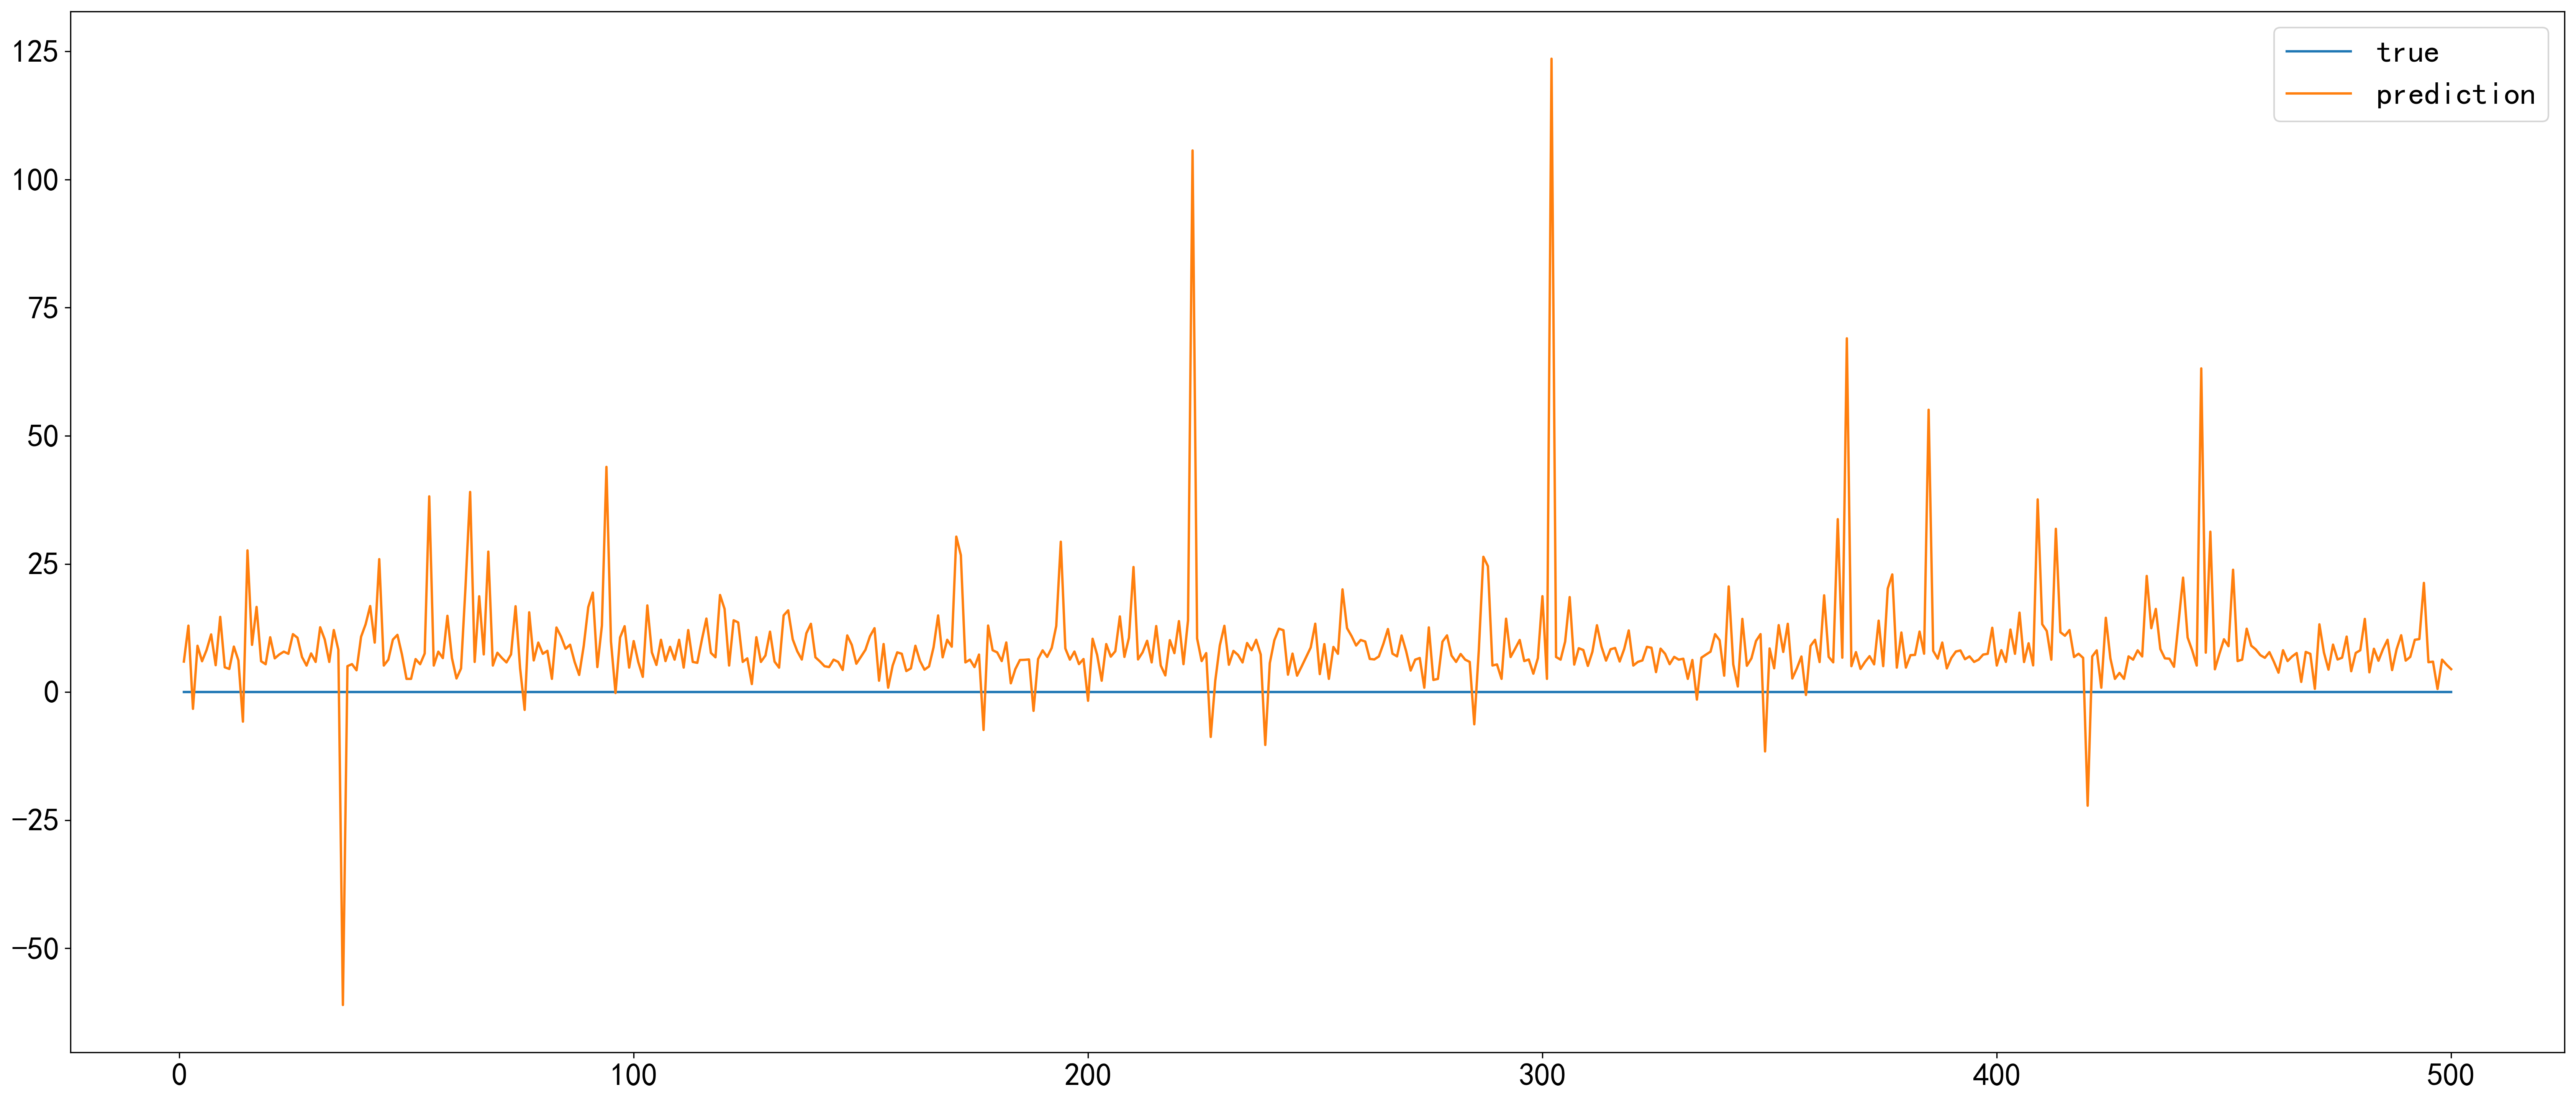

In [82]:
x_axis=np.linspace(1,len(trues),len(trues))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:500],trues[:500])
plt.plot(x_axis[:500],pres[:500])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

## 查看模型特征重要性，验证我们前期特征工程

In [83]:
model = joblib.load("models/model_105.pkl")
s = model.feature_importances_
s 
len(s)

features = [f for f in data.columns if f != '订单需求量']
len(features)

51

.ipynb_checkpoints
model_101.pkl
model_102.pkl
model_103.pkl
model_104.pkl
model_105.pkl


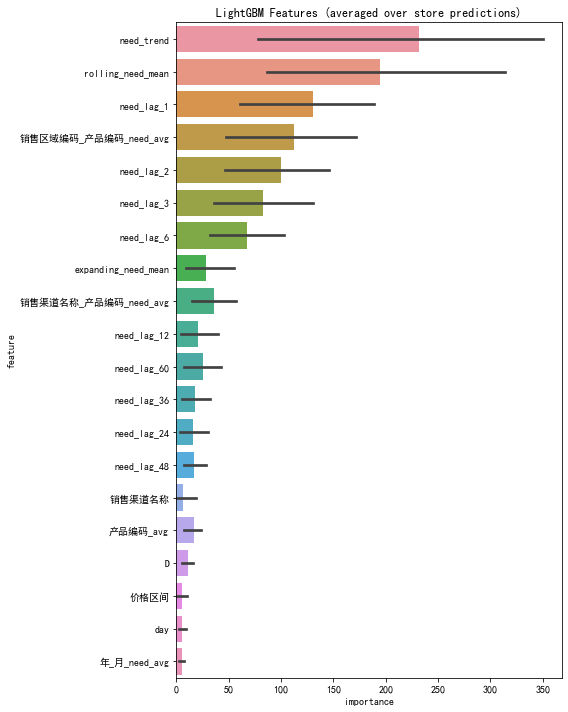

In [84]:
import os
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != '订单需求量']
# print(features)
for filename in os.listdir('./models'):
    print(filename)
    if 'model' in filename:
        # load model
        model = joblib.load("models/"+filename) 
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
        del model
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

# 预测样例数据结果

## 读取之前构造好的19年1月数据

In [85]:
result=[]
for v in eval_preds:
    if v<0:
        result.append(0)  #预测值里有负值，这是不可能的，所有我们用0来代表异常值，
    else:
        result.append(round(v,0))
# result

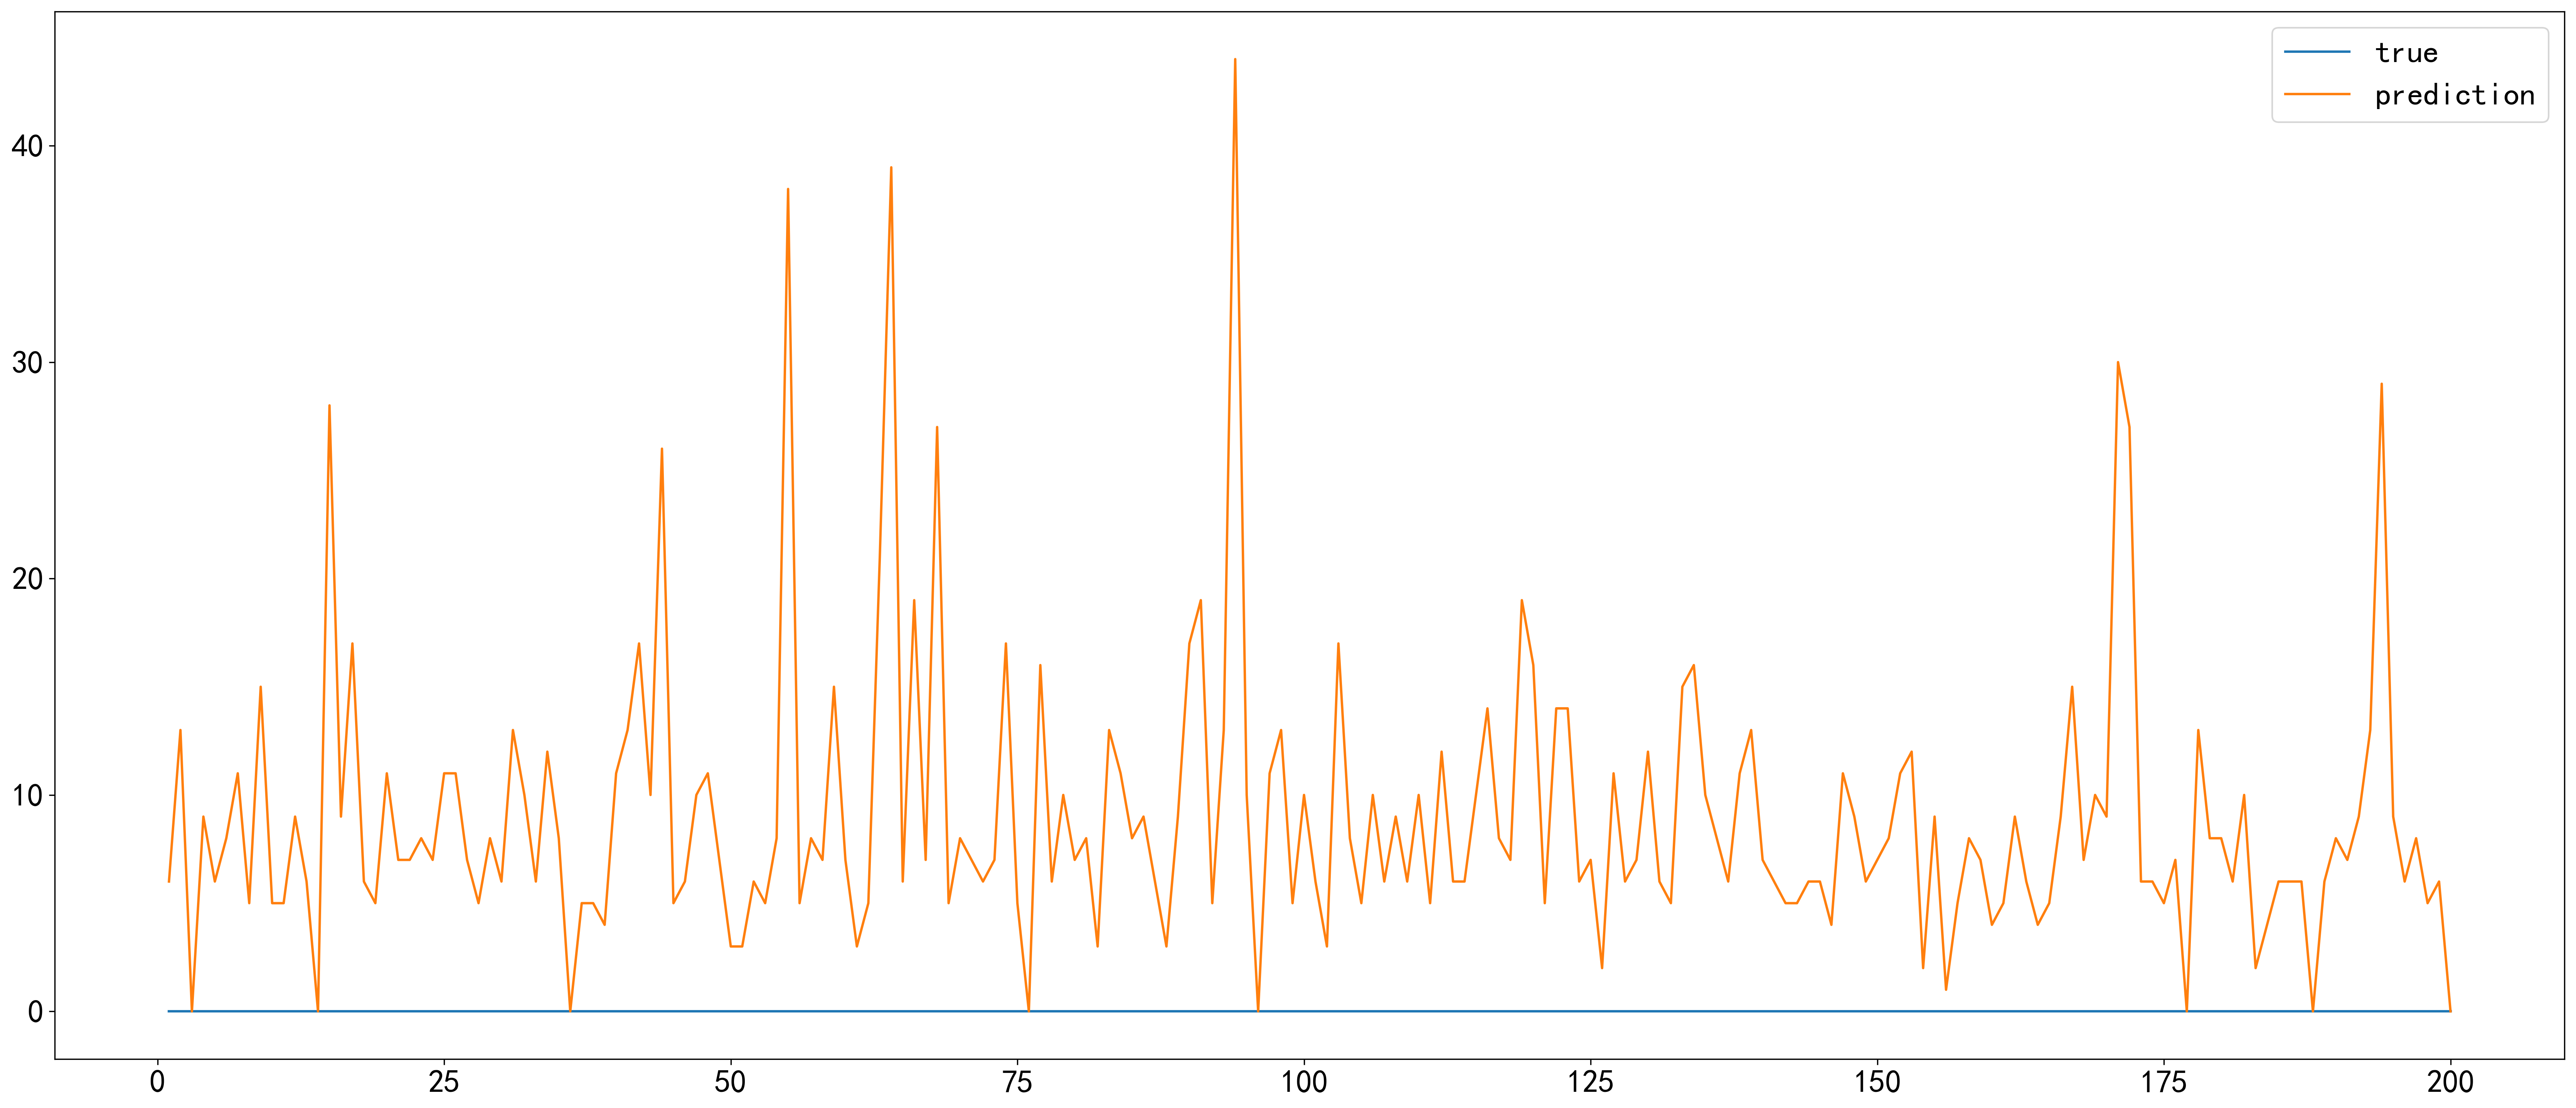

In [86]:
pres = result[:200]
pres
x_axis=np.linspace(1,len(trues),len(trues))
font1 = {'family' : 'SimSun','weight' : 'normal','size'   : 20,}
colors =['black','green','yellow','blue','cyan','red','orange','pink']
plt.figure(dpi=300,figsize=(28,12))


plt.plot(x_axis[:200],trues[:200])
plt.plot(x_axis[:200],pres[:200])
plt.legend(['true','prediction'],prop = {'size':20})
# plt.scatter(x_data,y_data_yuemo,color='blue')
plt.tick_params(labelsize=20)  #修改刻度显示大小

In [87]:
## d读取之前构造好的19年1月数据：
df_sub= pd.read_csv('data/构造19_01data(验证).csv')
df_sub

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
0,2018-12-15,101,20901,303,410,1,0,2018,12,15,1,0,1202,3,1,3,5,0
1,2018-12-15,103,21993,302,408,0,0,2018,12,15,1,0,1202,6,1,3,5,0
2,2018-12-15,105,20047,308,404,0,0,2018,12,15,1,0,1202,3,1,3,5,0
3,2018-12-15,105,22027,306,402,1,0,2018,12,15,1,0,1202,0,1,3,5,0
4,2018-12-15,102,20445,303,401,1,0,2018,12,15,1,0,1202,1,1,3,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103,20072,303,401,0,0,2019,1,31,0,0,1249,6,2,3,3,1
245228,2019-01-31,102,21136,305,412,0,0,2019,1,31,0,0,1249,3,2,3,3,1
245229,2019-01-31,101,20377,303,410,0,0,2019,1,31,0,0,1249,6,2,3,3,1
245230,2019-01-31,101,21018,306,407,0,0,2019,1,31,0,0,1249,4,2,3,3,1


In [88]:
x = pd.DataFrame(eval_preds)
x

,订单需求量
592900,5.950150
592901,12.958094
592902,-3.273416
592903,9.031911
592904,6.017512
...,...
838127,8.855943
838128,7.140364
838129,5.900137
838130,5.900137


## 将预测的各产品一月需求量值进行替换

In [89]:
df_sub['订单需求量'] = result  #把预测的订单需求量替换
# df_sub.to_csv('output/构造的1月数据预测结果.csv',index=False)
# df_sub

In [90]:
result_df1=df_sub.loc[df_sub['D']>=1219]  #定位到19年1月的数据
result_df1

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,订单需求量,Year,Month,day,是否节假日,是否促销日,D,价格区间,每月时间段,season_bm,星期几,is_workday
86853,2019-01-01,101,20901,303,410,1,4.0,2019,1,1,1,1,1219,3,0,3,1,0
86854,2019-01-01,103,21993,302,408,0,9.0,2019,1,1,1,1,1219,6,0,3,1,0
86855,2019-01-01,105,20047,308,404,0,5.0,2019,1,1,1,1,1219,3,0,3,1,0
86856,2019-01-01,105,22027,306,402,1,9.0,2019,1,1,1,1,1219,0,0,3,1,0
86857,2019-01-01,102,20445,303,401,1,11.0,2019,1,1,1,1,1219,1,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245227,2019-01-31,103,20072,303,401,0,9.0,2019,1,31,0,0,1249,6,2,3,3,1
245228,2019-01-31,102,21136,305,412,0,7.0,2019,1,31,0,0,1249,3,2,3,3,1
245229,2019-01-31,101,20377,303,410,0,6.0,2019,1,31,0,0,1249,6,2,3,3,1
245230,2019-01-31,101,21018,306,407,0,6.0,2019,1,31,0,0,1249,4,2,3,3,1


In [91]:
result_df = result_df1[['订单日期','销售区域编码','产品编码','产品大类编码','产品细类编码','订单需求量']]  #筛选出需要的列

result_df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量
86853,2019-01-01,101,20901,303,410,4.0
86854,2019-01-01,103,21993,302,408,9.0
86855,2019-01-01,105,20047,308,404,5.0
86856,2019-01-01,105,22027,306,402,9.0
86857,2019-01-01,102,20445,303,401,11.0
...,...,...,...,...,...,...
245227,2019-01-31,103,20072,303,401,9.0
245228,2019-01-31,102,21136,305,412,7.0
245229,2019-01-31,101,20377,303,410,6.0
245230,2019-01-31,101,21018,306,407,6.0


## 制作透视表，计算各产品一月的总需求量

In [92]:
#制作透视表得到所有产品19年1月的需求量
result_df = pd.pivot_table(result_df, index=['销售区域编码','产品大类编码','产品细类编码','产品编码'], columns='订单日期',
                                  values='订单需求量', aggfunc=np.sum,fill_value=1).reset_index()
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31
0,101,301,405,20003,14,15,15,15,15,15,14,15,15,15,15,15,15,14,14,15,15,15,14,14,14,14,14,14,15,14,15,15,15,15,15
1,101,301,405,20027,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
2,101,301,405,20085,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,101,301,405,20219,3,6,6,6,3,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
5105,105,308,404,22005,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5106,105,308,404,22018,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5107,105,308,404,22023,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [93]:
result_df.iloc[:,4:]

订单日期,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31
0,14,15,15,15,15,15,14,15,15,15,15,15,15,14,14,15,15,15,14,14,14,14,14,14,15,14,15,15,15,15,15
1,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
2,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
3,3,6,6,6,3,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
5105,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5106,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
5107,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7


In [94]:
result_df['1月总需求量'] = result_df.iloc[:,4:].sum(axis=1)  # 对0，1列按行求和，生成新列
result_df


订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,1月总需求量
0,101,301,405,20003,14,15,15,15,15,15,14,15,15,15,15,15,15,14,14,15,15,15,14,14,14,14,14,14,15,14,15,15,15,15,15,454
1,101,301,405,20027,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,248
2,101,301,405,20085,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,155
3,101,301,405,20219,3,6,6,6,3,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,180
4,101,301,405,20270,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,105,308,404,21981,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,217
5105,105,308,404,22005,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,186
5106,105,308,404,22018,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,155
5107,105,308,404,22023,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,217


In [95]:
result_df = result_df[['销售区域编码','产品大类编码','产品细类编码','产品编码','1月总需求量']]
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,1月总需求量
0,101,301,405,20003,454
1,101,301,405,20027,248
2,101,301,405,20085,155
3,101,301,405,20219,180
4,101,301,405,20270,186
...,...,...,...,...,...
5104,105,308,404,21981,217
5105,105,308,404,22005,186
5106,105,308,404,22018,155
5107,105,308,404,22023,217


In [96]:
#CESHI

result_df['zuhe'] = result_df['销售区域编码'].astype(str)+'_'+result_df['产品大类编码'].astype(str)+'_'+result_df['产品细类编码'].astype(str)+'_'+result_df['产品编码'].astype(str)
result_df

订单日期,销售区域编码,产品大类编码,产品细类编码,产品编码,1月总需求量,zuhe
0,101,301,405,20003,454,101_301_405_20003
1,101,301,405,20027,248,101_301_405_20027
2,101,301,405,20085,155,101_301_405_20085
3,101,301,405,20219,180,101_301_405_20219
4,101,301,405,20270,186,101_301_405_20270
...,...,...,...,...,...,...
5104,105,308,404,21981,217,105_308_404_21981
5105,105,308,404,22005,186,105_308_404_22005
5106,105,308,404,22018,155,105_308_404_22018
5107,105,308,404,22023,217,105_308_404_22023


## 读入predict_sku0.csv，进行匹配汇总，得到结果

In [97]:
# 读入predict_sku0.csv，进行匹配汇总，predict_sku0中的产品的1月需求量：
predict_df = pd.read_csv("../B题-全部数据//predict_sku1.csv")
predict_df.columns =['销售区域编码','产品编码','产品大类编码','产品细类编码',]
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
...,...,...,...,...
2614,105,22066,307,403
2615,105,22072,305,412
2616,105,22075,307,403
2617,105,22083,303,401


In [98]:
#测试，查看predict_sku1中的新产品

predict_df['zuhe'] = predict_df['销售区域编码'].astype(str)+'_'+predict_df['产品大类编码'].astype(str)+'_'+predict_df['产品细类编码'].astype(str)+'_'+predict_df['产品编码'].astype(str)
predict_df

,销售区域编码,产品编码,产品大类编码,产品细类编码,zuhe
0,101,20002,303,406,101_303_406_20002
1,101,20003,301,405,101_301_405_20003
2,101,20006,307,403,101_307_403_20006
3,101,20011,303,401,101_303_401_20011
4,101,20014,307,403,101_307_403_20014
...,...,...,...,...,...
2614,105,22066,307,403,105_307_403_22066
2615,105,22072,305,412,105_305_412_22072
2616,105,22075,307,403,105_307_403_22075
2617,105,22083,303,401,105_303_401_22083


In [99]:
ls = list(result_df['zuhe'])
ls 
count =0 
for v in predict_df['zuhe']:
    if v not in ls: 
        
#         print(v)
        count+=1
print("新产品",count)
        

新产品 432


In [100]:
s=pd.merge(predict_df,result_df,how='inner')
s.drop('zuhe',axis=1,inplace=True)
s

,销售区域编码,产品编码,产品大类编码,产品细类编码,1月总需求量
0,101,20002,303,406,248
1,101,20003,301,405,454
2,101,20006,307,403,155
3,101,20014,307,403,591
4,101,20016,303,401,124
...,...,...,...,...,...
2182,105,22059,305,412,217
2183,105,22066,307,403,403
2184,105,22072,305,412,248
2185,105,22083,303,401,217


没匹配到的432个为新产品，后续单独试试产品相似度去预测

In [101]:
s.to_csv('output/样本数据预测的1月predict_sku1.csv',index=False)

In [102]:
#因为 1202 原本有数据，所有在元数据与构造数据拼接的时候，要把原本有1202的数据给删除掉，不然就会多了